In [188]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [190]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [191]:
TARGET_COLUMN = 'vocal_channel'

In [192]:
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

In [193]:
one_hot = pd.get_dummies(df[TARGET_COLUMN])
df = df.join(one_hot)
df = df.drop([TARGET_COLUMN], axis=1)

In [194]:
def plot_percentage(data, columns):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=(10, 6))
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    plt.show()

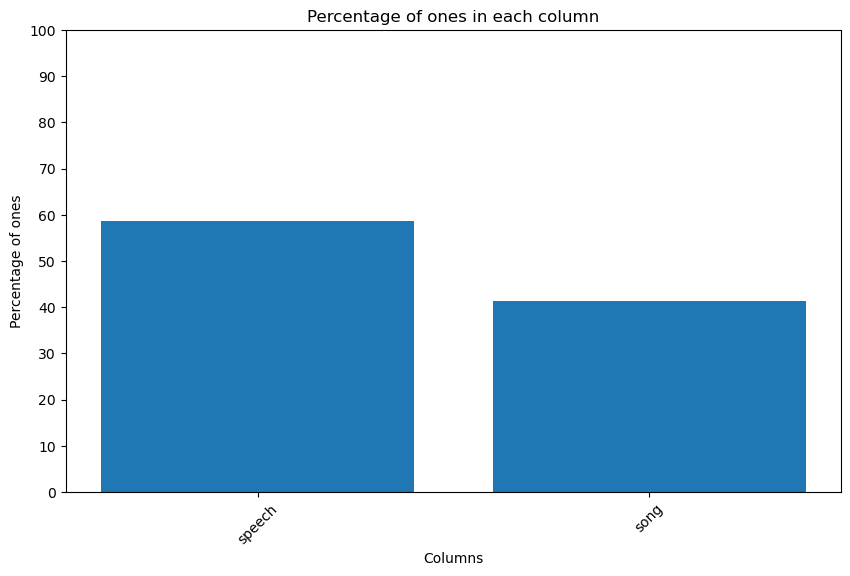

In [195]:
plot_percentage(df, values)

## Visualize the target class

In [196]:
TARGET_CLASS = 'song'

In [197]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using Isomap')
    plt.show()

In [198]:
from sklearn.decomposition import PCA

def pca_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using PCA')
    plt.show()

In [199]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

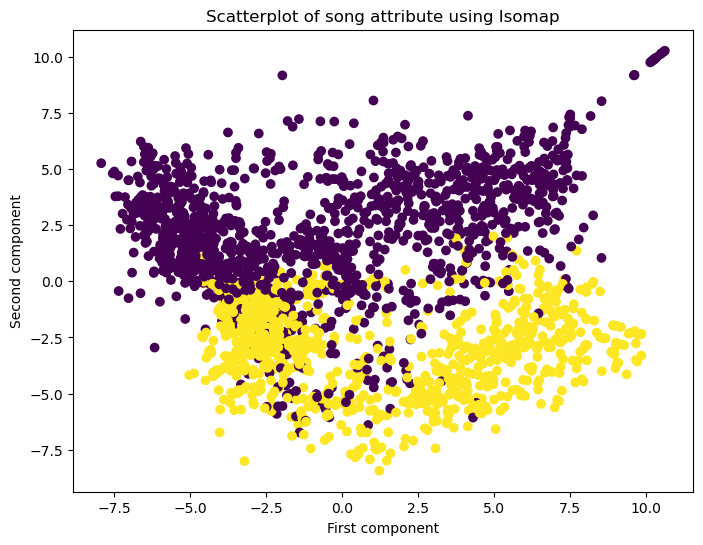

In [200]:
isomap_by_class(df[numerical_attr_list], values, TARGET_CLASS)

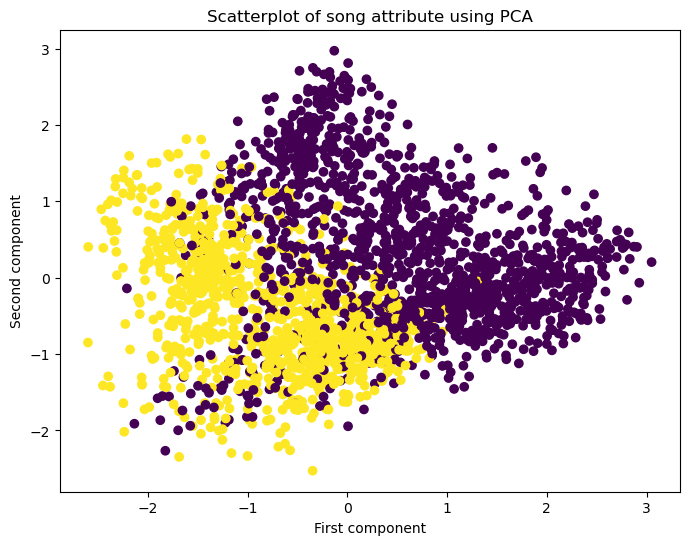

In [201]:
pca_by_class(df[numerical_attr_list], values, TARGET_CLASS)

## Dataset imbalance

In [202]:
from sklearn.model_selection import train_test_split

split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df[:split_index]
df_test = df[split_index:]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)




In [203]:
target_class_count_t = df_train[TARGET_CLASS].sum()
target_class_count_v = df_valid[TARGET_CLASS].sum()
other_class_count_t = df_train.shape[0] - target_class_count_t
other_class_count_v = df_valid.shape[0] - target_class_count_v
eight_percent_t = int(other_class_count_t * 8 / 100)
eight_percent_v = int(other_class_count_v * 8 / 100)

# target class is 8% the size of the other one
rows_to_keep_t = np.random.choice(df_train[df_train[TARGET_CLASS] == 1].index, eight_percent_t, replace=False)
rows_to_keep_v = np.random.choice(df_valid[df_valid[TARGET_CLASS] == 1].index, eight_percent_v, replace=False)
df_train = df_train[(df_train[TARGET_CLASS] == 1 & df_train.index.isin(rows_to_keep_t)) | (df_train[TARGET_CLASS] == 0)]
df_valid = df_valid[(df_valid[TARGET_CLASS] == 1 & df_valid.index.isin(rows_to_keep_v)) | (df_valid[TARGET_CLASS] == 0)]

df_valid = df_valid.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

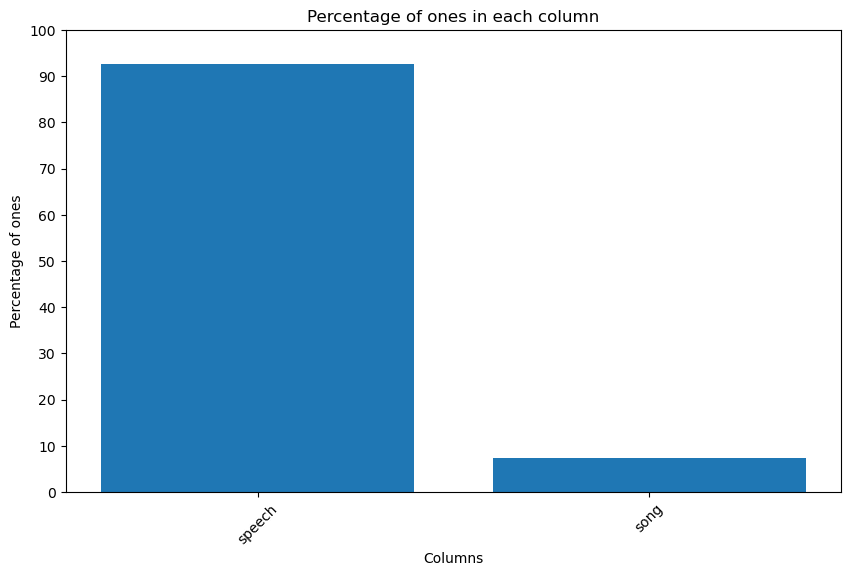

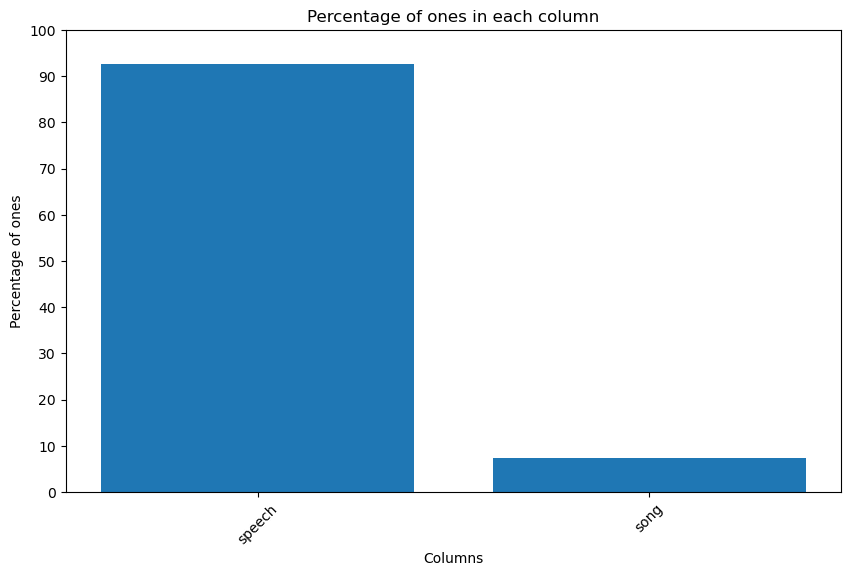

In [204]:
plot_percentage(df_train, values)
plot_percentage(df_valid, values)

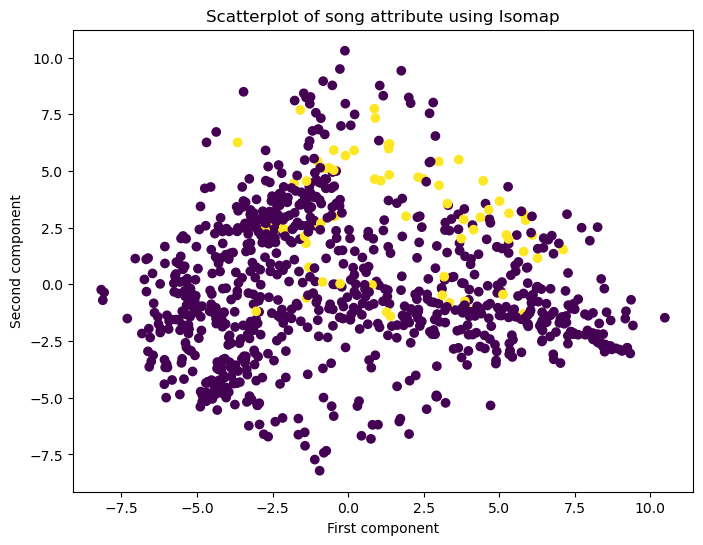

In [205]:
isomap_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

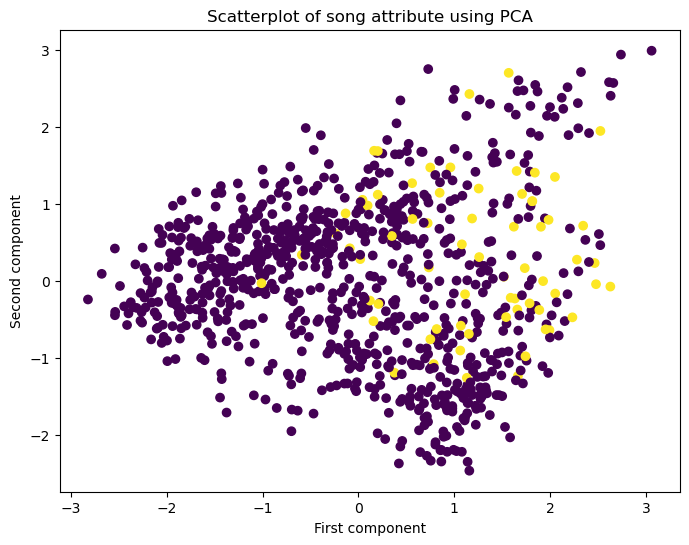

In [206]:
pca_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

# Dataset preparation

In [207]:
target_train = df_train[TARGET_CLASS]
target_valid = df_valid[TARGET_CLASS]
target_test = df_test[TARGET_CLASS]

display(df_train.shape, df_valid.shape, df_test.shape)

(910, 251)

(247, 251)

(616, 251)

In [208]:
excluded_prefixes = ['zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(values, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)) and column != TARGET_COLUMN:
        columns_to_keep.append(column)

# selected features without target
columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_std',
 'lag1_min',
 'lag1_max',
 'lag1_q01',
 'lag1_q05',
 'lag1_q25',
 'lag1_q75',
 'lag1_q95',
 'lag1_q99',
 'lag1_kur',
 'lag1_skew',
 'mfcc_sum',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'mfcc_q01',
 'mfcc_q05',
 'mfcc_q25',
 'mfcc_q50',
 'mfcc_q75',
 'mfcc_q95',
 'mfcc_q99',
 'mfcc_kur',
 'mfcc_skew',
 'sc_sum',
 'sc_mean',
 'sc_std',
 'sc_min',
 'sc_max',
 'sc_q01',
 'sc_q05',
 'sc_q25',
 'sc_q50',
 'sc_q75',
 'sc_q95',
 'sc_q99',
 'sc_kur',
 'sc_skew',
 'stft_sum',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_q01',
 'stft_q05',
 'stft_q25',
 'stft_q50',
 'stft_q75',
 'stft_kur',
 'stft_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_sum_w1',
 'lag1_max_w1',
 'lag1_q05_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'mfcc_sum_w1',
 'mfcc_mean_w1',
 'mfcc_std_w1',
 'mfcc_max_w1',
 'mfcc_q01_w1',
 'mfcc_q05_w1',
 

In [209]:
df_train = df_train.drop(df_train.columns.difference(columns_to_keep), axis=1)
df_valid = df_valid.drop(df_valid.columns.difference(columns_to_keep), axis=1)
df_test = df_test.drop(df_test.columns.difference(columns_to_keep), axis=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [210]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_valid = scaler.fit_transform(df_valid)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_valid = target_valid.to_numpy()
y_test = target_test.to_numpy()

# Undersampling
## CNN

In [211]:
from collections import Counter
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1)

X_res_t, y_res_t = cnn.fit_resample(X_train, y_train)
X_res_v, y_res_v = cnn.fit_resample(X_valid, y_valid)

print(f'Starting dataset shape: train {Counter(y_train)}   validation {Counter(y_valid)}')
print(f'Resampled dataset shape: train {Counter(y_res_t)}   validation {Counter(y_res_v)}')

Starting dataset shape: train Counter({0: 843, 1: 67})   validation Counter({0: 229, 1: 18})
Resampled dataset shape: train Counter({0: 75, 1: 67})   validation Counter({0: 22, 1: 18})


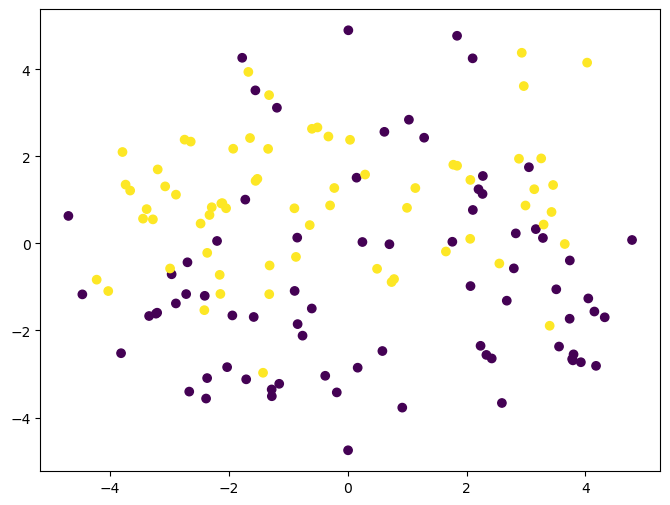

In [212]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res_t)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res_t, cmap='viridis')
plt.show()

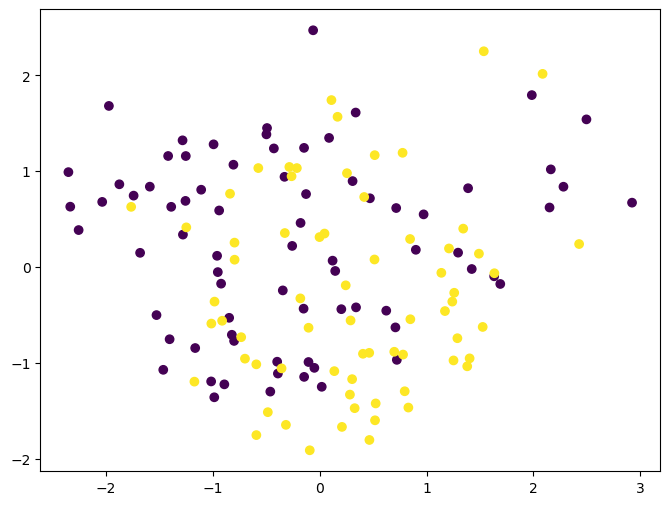

In [213]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res_t)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res_t, cmap='viridis')
plt.show()

# Logistic Regression

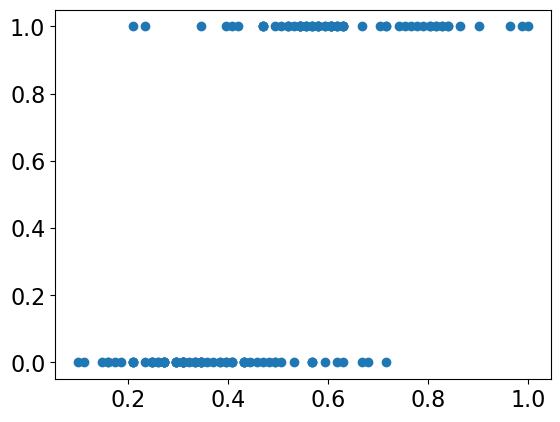

In [214]:
plt.scatter(X_res_t.T[0], y_res_t)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [215]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [216]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])
    

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_res_t, y_res_t)
    y_pred = logr.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-10 14:45:46,258] A new study created in memory with name: no-name-8df501ac-dfa0-4cf6-bfb2-270125c4ab76
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[W 2023-06-10 14:45:46,258] Trial 0 failed with parameters: {'penalty': 'elasticnet', 'C': 9.485548658434325, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.pe

[W 2023-06-10 14:45:46,373] Trial 14 failed with value None.
[I 2023-06-10 14:45:46,368] Trial 10 finished with value: 1.0 and parameters: {'penalty': 'none', 'C': 2.768595853247939, 'solver': 'sag'}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:46,358] Trial 12 finished with value: 0.95 and parameters: {'penalty': 'l1', 'C': 4.101586098392404, 'solver': 'liblinear'}. Best is trial 2 with value: 1.0.
[W 2023-06-10 14:45:46,378] Trial 17 failed with parameters: {'penalty': 'elasticnet', 'C': 0.21491670739773816, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\

[W 2023-06-10 14:45:46,478] Trial 27 failed with parameters: {'penalty': 'elasticnet', 'C': 6.372013786508993, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 457, in _check_solver
    raise ValueError(
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
[W 2023-06-10 14:45:46,478] Trial 24 failed with value Non

[W 2023-06-10 14:45:46,594] Trial 35 failed with parameters: {'penalty': 'elasticnet', 'C': 6.390870442346381, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:46,594] Trial 31

[W 2023-06-10 14:45:46,687] Trial 37 failed with value None.
[W 2023-06-10 14:45:46,688] Trial 43 failed with parameters: {'penalty': 'elasticnet', 'C': 9.945634757623838, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties,

[W 2023-06-10 14:45:46,770] Trial 45 failed with value None.
[W 2023-06-10 14:45:46,778] Trial 51 failed with parameters: {'penalty': 'elasticnet', 'C': 6.8753513034464, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, g

[W 2023-06-10 14:45:46,861] Trial 59 failed with parameters: {'penalty': 'elasticnet', 'C': 6.715919334184783, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:46,861] Trial 54

[W 2023-06-10 14:45:46,948] Trial 67 failed with parameters: {'penalty': 'elasticnet', 'C': 9.779275535831918, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:46,948] Trial 63

[W 2023-06-10 14:45:47,028] Trial 75 failed with parameters: {'penalty': 'elasticnet', 'C': 6.685840210661526, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,028] Trial 71

[W 2023-06-10 14:45:47,119] Trial 79 failed with value None.
[W 2023-06-10 14:45:47,120] Trial 83 failed with parameters: {'penalty': 'elasticnet', 'C': 9.996633460036321, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties,

[W 2023-06-10 14:45:47,207] Trial 91 failed with parameters: {'penalty': 'elasticnet', 'C': 6.635095810385041, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,211] Trial 92

[W 2023-06-10 14:45:47,310] Trial 99 failed with parameters: {'penalty': 'elasticnet', 'C': 9.959950794967735, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,311] Trial 10

[W 2023-06-10 14:45:47,391] Trial 108 failed with parameters: {'penalty': 'elasticnet', 'C': 6.693234339232539, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,408] Trial 1

[W 2023-06-10 14:45:47,478] Trial 115 failed with parameters: {'penalty': 'elasticnet', 'C': 9.711026585262307, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,488] Trial 1

[W 2023-06-10 14:45:47,594] Trial 125 failed with parameters: {'penalty': 'elasticnet', 'C': 9.91823986559579, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,594] Trial 12

[W 2023-06-10 14:45:47,698] Trial 133 failed with parameters: {'penalty': 'elasticnet', 'C': 6.782357049316145, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-10 14:45:47,698] Trial 1

[W 2023-06-10 14:45:47,793] Trial 137 failed with value None.
[W 2023-06-10 14:45:47,806] Trial 141 failed with parameters: {'penalty': 'elasticnet', 'C': 6.6833024880266025, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 457, in _check_solver
    raise ValueError(
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=libli

[W 2023-06-10 14:45:47,918] Trial 146 failed with value None.
[W 2023-06-10 14:45:47,920] Trial 147 failed with value None.
[W 2023-06-10 14:45:47,921] Trial 148 failed with value None.
[W 2023-06-10 14:45:47,922] Trial 145 failed with value None.
[W 2023-06-10 14:45:47,923] Trial 149 failed with value None.


In [217]:
best_params = study.best_params

logr = LogisticRegression(**best_params)
logr.fit(X_res_t.T[0].reshape(-1,1), y_res_t)

y_pred_test = logr.predict(X_test.T[0].reshape(-1,1))


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 7.858140238525655, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       354
           1       0.93      0.86      0.89       262

    accuracy                           0.91       616
   macro avg       0.91      0.91      0.91       616
weighted avg       0.91      0.91      0.91       616

Accuracy 0.9123376623376623
F1-score [0.92561983 0.89328063]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

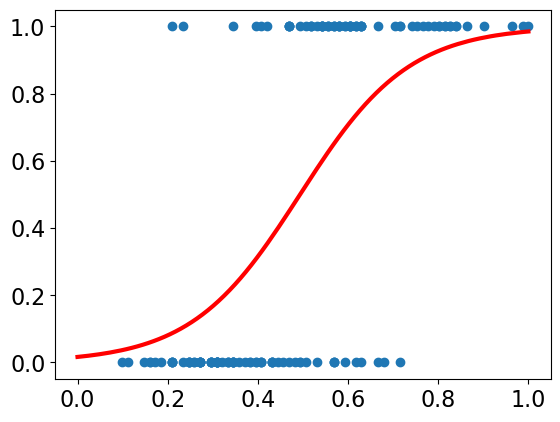

In [218]:
from scipy.special import expit

loss = expit(sorted(X_test.T[0].reshape(-1,1)) *logr.coef_.T[0] + logr.intercept_).ravel()
plt.plot(sorted(X_test.T[0].reshape(-1,1)), loss, color='red', linewidth=3)
plt.scatter(X_res_t.T[0].reshape(-1,1), y_res_t)
#plt.xlabel(selected_columns[0], fontsize=16)
#plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

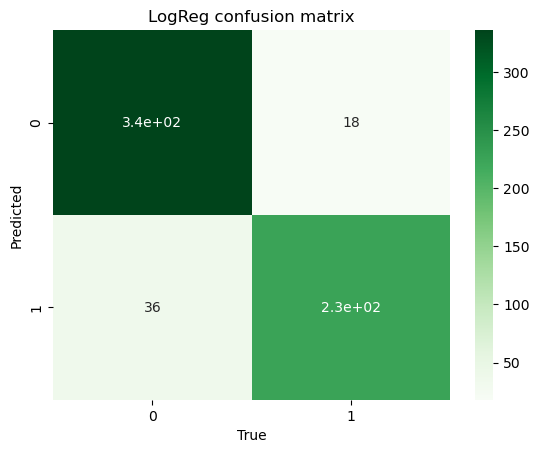

In [219]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LogReg confusion matrix')
plt.show()

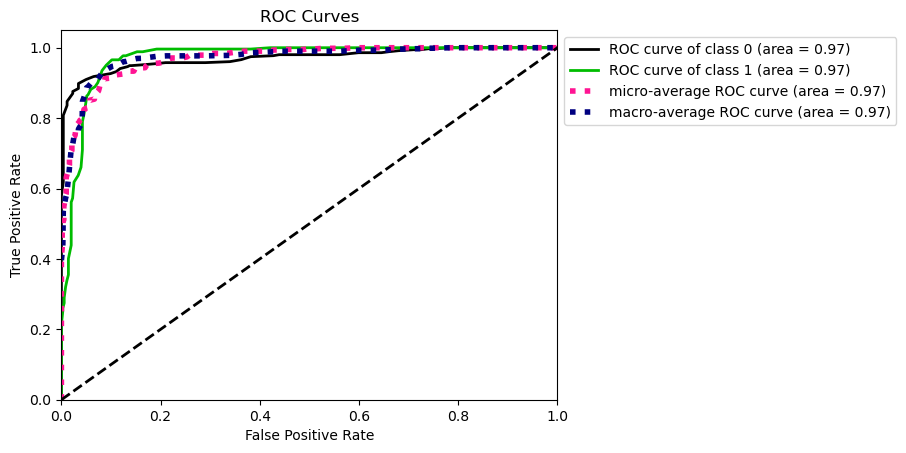

0.9701826454478804


In [220]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = logr.predict_proba(X_test.T[0].reshape(-1,1))
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

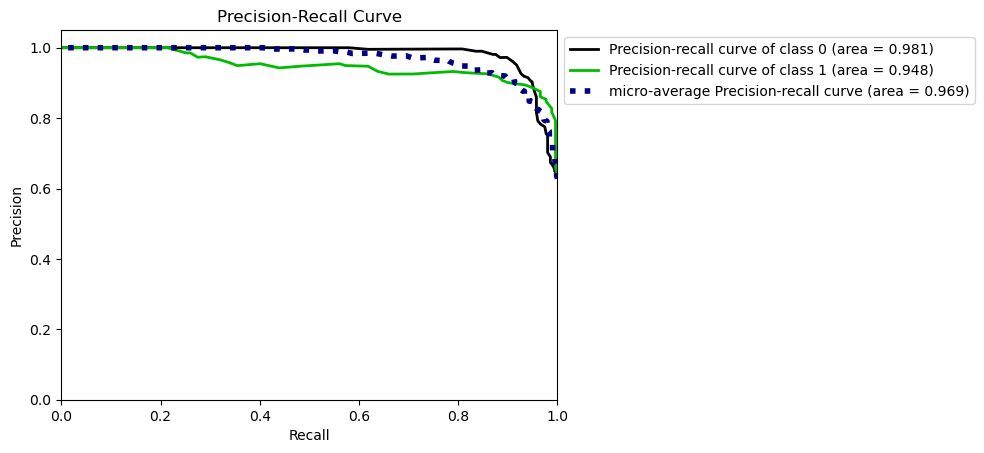

In [221]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(y_test, logr.predict_proba(X_test.T[0].reshape(-1,1)))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Suppport Vector Machine

In [222]:
pca = PCA(n_components=2)
pca.fit(X_res_t)
X_pca = pca.transform(X_res_t)

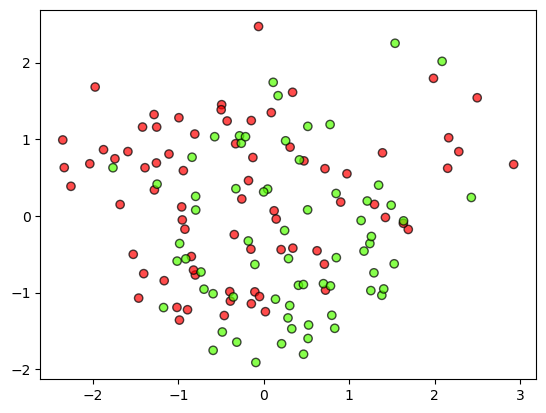

In [223]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Linear SVM

In [224]:
from sklearn.svm import LinearSVC

In [225]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    

    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-10 14:45:48,726] A new study created in memory with name: no-name-36c363b9-9291-494f-a520-88b02c93569e
[W 2023-06-10 14:45:48,732] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 19.311214321099254, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base

[W 2023-06-10 14:45:48,762] Trial 3 failed with value None.
[W 2023-06-10 14:45:48,767] Trial 5 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-10 14:45:48,769] Trial 6 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-10 14:45:48,774] Trial 9 failed with parameters: {'penalty': 'l1', 'C': 39.41837152019846, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = fun

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-10 14:45:48,816] Trial 18 failed with value None.
[W 2023-06-10 14:45:48,817] Trial 20 failed with value None.
[I 2023-06-10 14:45:48,819] Trial 12 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 9.361898288401024, 'loss': 'hinge'}. Best is trial 4 with value: 1.0.
[W 2023-06-10 14:45:48,822] Trial 21 failed with parameters: {'penalty': 'l1', 'C': 30.187537101575796, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipyker

[W 2023-06-10 14:45:48,856] Trial 26 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-10 14:45:48,859] Trial 30 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-10 14:45:48,866] Trial 32 failed with parameters: {'penalty': 'l1', 'C': 26.5739110040346, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykern

[W 2023-06-10 14:45:48,936] Trial 36 failed with parameters: {'penalty': 'l1', 'C': 75.2789975831515, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
 

[W 2023-06-10 14:45:48,988] Trial 41 failed with value None.
[W 2023-06-10 14:45:48,998] Trial 43 failed with parameters: {'penalty': 'l1', 'C': 74.94588241362604, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, 

[W 2023-06-10 14:45:49,062] Trial 43 failed with value None.
[W 2023-06-10 14:45:49,062] Trial 44 failed with value None.
[W 2023-06-10 14:45:49,062] Trial 45 failed with value None.
[W 2023-06-10 14:45:49,068] Trial 46 failed with value None.
[W 2023-06-10 14:45:49,070] Trial 47 failed with value None.
[W 2023-06-10 14:45:49,086] Trial 48 failed with value None.
[W 2023-06-10 14:45:49,086] Trial 50 failed with parameters: {'penalty': 'l1', 'C': 76.08204407943664, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_

[W 2023-06-10 14:45:49,142] Trial 56 failed with parameters: {'penalty': 'l1', 'C': 76.4190146112658, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
 

[W 2023-06-10 14:45:49,228] Trial 58 failed with value None.
[W 2023-06-10 14:45:49,228] Trial 62 failed with parameters: {'penalty': 'l1', 'C': 75.36545203367315, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, 

[W 2023-06-10 14:45:49,304] Trial 69 failed with parameters: {'penalty': 'l1', 'C': 77.5283694670641, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\emanu\anaconda3\lib\site

[W 2023-06-10 14:45:49,356] Trial 72 failed with value None.
[W 2023-06-10 14:45:49,357] Trial 73 failed with value None.
[W 2023-06-10 14:45:49,368] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 75.71741320648063, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_libline

[W 2023-06-10 14:45:49,440] Trial 83 failed with parameters: {'penalty': 'l1', 'C': 76.64323901141236, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-10 14:45:49,503] Trial 85 failed with value None.
[W 2023-06-10 14:45:49,504] Trial 86 failed with value None.
[W 2023-06-10 14:45:49,505] Trial 87 failed with value None.
[W 2023-06-10 14:45:49,524] Trial 90 failed with parameters: {'penalty': 'l1', 'C': 75.62169232024725, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\si

[W 2023-06-10 14:45:49,593] Trial 96 failed with parameters: {'penalty': 'l1', 'C': 76.45624930097142, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\emanu\anaconda3\lib\sit

[W 2023-06-10 14:45:49,674] Trial 103 failed with parameters: {'penalty': 'l1', 'C': 75.92574576064112, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\emanu\anaconda3\lib\si

[W 2023-06-10 14:45:49,759] Trial 109 failed with parameters: {'penalty': 'l1', 'C': 77.48513951679139, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)

[W 2023-06-10 14:45:49,829] Trial 112 failed with value None.
[W 2023-06-10 14:45:49,829] Trial 113 failed with value None.
[W 2023-06-10 14:45:49,843] Trial 117 failed with parameters: {'penalty': 'l1', 'C': 76.70699070730635, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_libl

[W 2023-06-10 14:45:49,905] Trial 119 failed with value None.
[W 2023-06-10 14:45:49,905] Trial 123 failed with parameters: {'penalty': 'l1', 'C': 74.0310729462198, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class,

[W 2023-06-10 14:45:49,987] Trial 126 failed with value None.
[W 2023-06-10 14:45:49,994] Trial 130 failed with parameters: {'penalty': 'l1', 'C': 72.67875537287831, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class

[W 2023-06-10 14:45:50,072] Trial 133 failed with value None.
[W 2023-06-10 14:45:50,073] Trial 137 failed with parameters: {'penalty': 'l1', 'C': 76.5110616827327, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type =

[W 2023-06-10 14:45:50,140] Trial 139 failed with value None.
[W 2023-06-10 14:45:50,141] Trial 140 failed with value None.
[W 2023-06-10 14:45:50,160] Trial 141 failed with value None.
[W 2023-06-10 14:45:50,161] Trial 143 failed with parameters: {'penalty': 'l1', 'C': 76.35033286414792, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblin

[W 2023-06-10 14:45:50,209] Trial 144 failed with value None.
[W 2023-06-10 14:45:50,209] Trial 145 failed with value None.
[W 2023-06-10 14:45:50,209] Trial 146 failed with value None.
[W 2023-06-10 14:45:50,218] Trial 147 failed with value None.
[W 2023-06-10 14:45:50,220] Trial 149 failed with value None.
[W 2023-06-10 14:45:50,221] Trial 148 failed with value None.


In [226]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(X_res_t, y_res_t)

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'penalty': 'l2', 'C': 85.5306134081674, 'loss': 'hinge'}
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       354
           1       0.98      0.90      0.94       262

    accuracy                           0.95       616
   macro avg       0.96      0.95      0.95       616
weighted avg       0.95      0.95      0.95       616

Accuracy 0.952922077922078
F1-score [0.96021948 0.94234592]


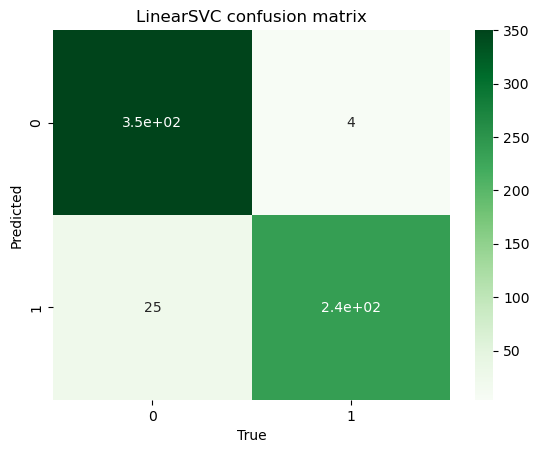

In [227]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

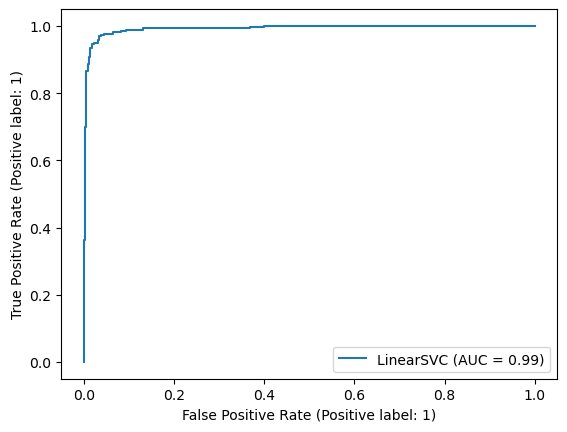

In [228]:
from sklearn.metrics import RocCurveDisplay

linear_svc_disp = RocCurveDisplay.from_estimator(lin_svc, X_test, y_test)

In [229]:
decision_function = lin_svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [230]:
support_vectors_pca = pca.transform(support_vectors)

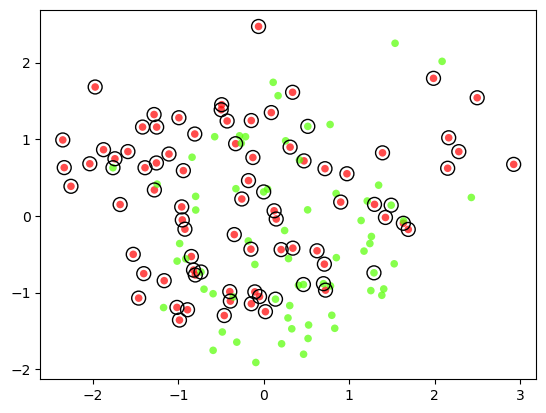

In [231]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


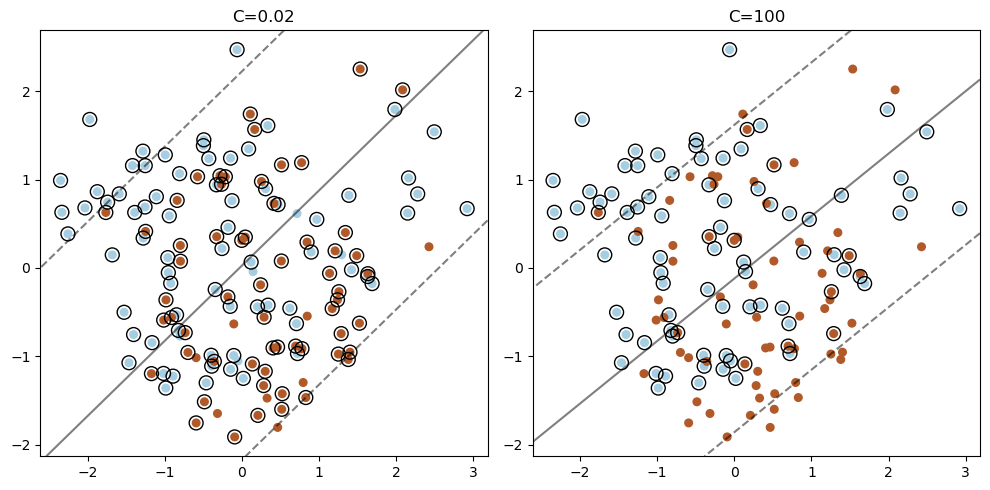

In [232]:
plt.figure(figsize=(10, 5))
for i, C in enumerate([0.02, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="squared_hinge", penalty='l2', random_state=42).fit(X_res_t, y_res_t)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X_res_t)
#     we can also calculate the decision function manually
#     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
    support_vectors = X_res_t[support_vector_indices]
    support_vectors_pca = pca.transform(support_vectors)

    plt.subplot(1, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.show()

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [233]:
from sklearn.svm import SVC

In [234]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01,100)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-10 14:45:51,030] A new study created in memory with name: no-name-e82b5576-0b09-483d-98f9-ec3dda8d30cd
[I 2023-06-10 14:45:51,038] Trial 0 finished with value: 0.55 and parameters: {'kernel': 'sigmoid', 'C': 3.912769542778994, 'gamma': 0.10442148688944121}. Best is trial 0 with value: 0.55.
[I 2023-06-10 14:45:51,054] Trial 2 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 48.48872764549253, 'gamma': 0.2916095722925239}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,060] Trial 1 finished with value: 0.55 and parameters: {'kernel': 'rbf', 'C': 46.88583461527878, 'gamma': 0.9107752454052339}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,060] Trial 4 finished with value: 0.55 and parameters: {'kernel': 'sigmoid', 'C': 93.04036385673717, 'gamma': 0.42615874838572354}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,060] Trial 3 finished with value: 0.55 and parameters: {'kernel': 'sigmoid', 'C': 60.4255169362901, 'gamma': 0.605777024

[I 2023-06-10 14:45:51,854] Trial 44 finished with value: 0.7 and parameters: {'kernel': 'sigmoid', 'C': 45.097831904329475, 'gamma': 0.07332725411256773}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,858] Trial 45 finished with value: 0.55 and parameters: {'kernel': 'sigmoid', 'C': 32.26941324958339, 'gamma': 0.3931070814230334}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,893] Trial 46 finished with value: 0.725 and parameters: {'kernel': 'rbf', 'C': 31.75682052460239, 'gamma': 0.45115300622287413}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,908] Trial 47 finished with value: 0.775 and parameters: {'kernel': 'rbf', 'C': 33.059226609589, 'gamma': 0.38946786853449583}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,908] Trial 49 finished with value: 0.875 and parameters: {'kernel': 'rbf', 'C': 33.69134964222877, 'gamma': 0.2209902178604042}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:51,908] Trial 51 finished with value: 0.875 and 

[I 2023-06-10 14:45:52,738] Trial 89 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 42.12958886055106, 'gamma': 0.12580513020716966}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:52,778] Trial 90 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 42.11719255766871, 'gamma': 0.2817434695200257}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:52,793] Trial 91 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 18.69380254165182, 'gamma': 0.29146638555032023}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:52,848] Trial 92 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 42.12287325688876, 'gamma': 0.298117318332957}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:52,858] Trial 93 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 25.130590997121374, 'gamma': 0.15908605369320372}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:52,858] Trial 94 finished with value: 1.0 and parameters:

[I 2023-06-10 14:45:53,688] Trial 134 finished with value: 0.875 and parameters: {'kernel': 'rbf', 'C': 20.27051451712827, 'gamma': 0.23957087047360118}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:53,706] Trial 135 finished with value: 0.875 and parameters: {'kernel': 'rbf', 'C': 20.472686435712603, 'gamma': 0.23939776265214546}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:53,720] Trial 133 finished with value: 0.875 and parameters: {'kernel': 'rbf', 'C': 48.65842422262773, 'gamma': 0.2322159331685118}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:53,758] Trial 136 finished with value: 0.875 and parameters: {'kernel': 'rbf', 'C': 20.586633043819933, 'gamma': 0.24417148139175002}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:53,758] Trial 139 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 40.37344763467367, 'gamma': 0.29345828002915697}. Best is trial 2 with value: 1.0.
[I 2023-06-10 14:45:53,773] Trial 138 finished with value: 0.875 

In [235]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(X_res_t, y_res_t)

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'poly', 'C': 48.48872764549253, 'gamma': 0.2916095722925239}
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       354
           1       0.98      0.93      0.95       262

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616

Accuracy 0.9594155844155844
F1-score [0.96532594 0.95107632]


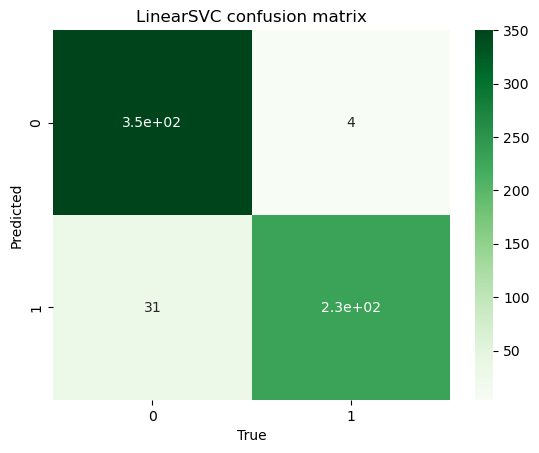

In [236]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

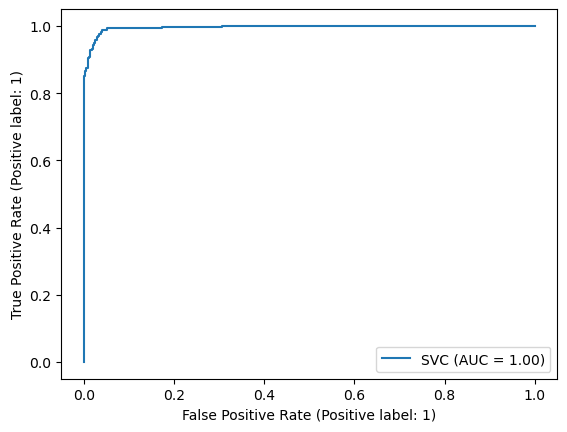

In [237]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

In [238]:
support_vectors_pca = pca.transform(svc.support_vectors_)

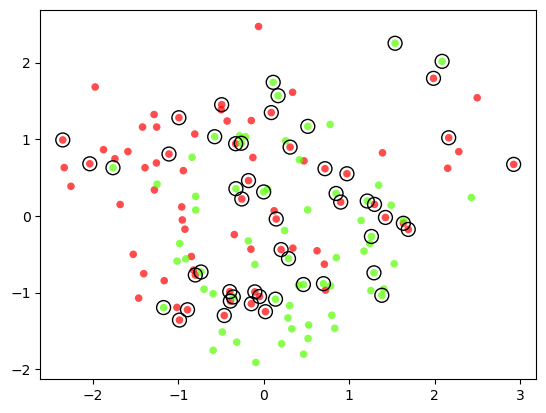

In [239]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [240]:
decision_function = svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [241]:
support_vectors_pca = pca.transform(support_vectors)

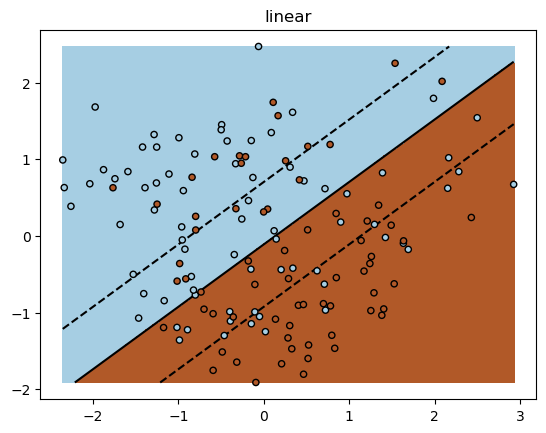

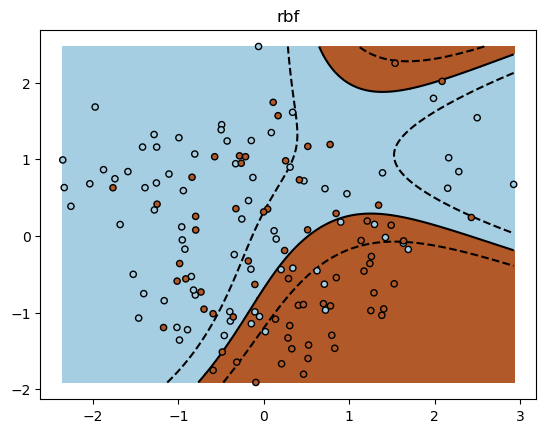

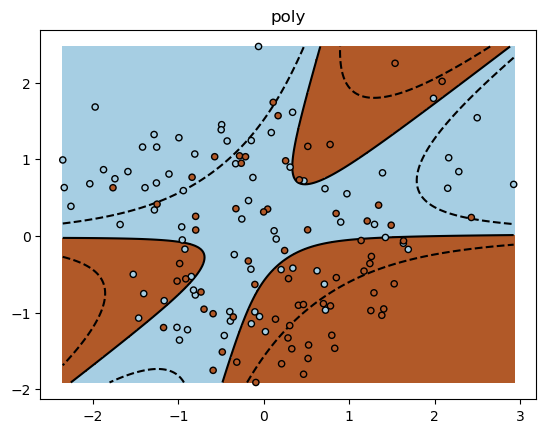

In [242]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=0.1, C=26)
    clf.fit(X_res_t, y_res_t)

    plt.figure()
    plt.clf()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
#     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
#                 zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    clf.fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [243]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [244]:
from scikeras.wrappers import KerasClassifier

In [245]:
from sklearn.model_selection import RandomizedSearchCV

In [246]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [247]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [248]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    net.fit(X_res_t, y_res_t, epochs=50)
    y_pred = net.predict(X_res_v).astype(int)
#     print(y_pred.shape, y_res_v.shape)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-10 14:45:55,798] A new study created in memory with name: no-name-edaaf896-8dbe-4611-9e5a-a49cb6d78239
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributio

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
5/5 [==============================] - 6s 10ms/step - loss: 0.7807 - accuracy: 0.3873
Epoch 2/50
5/5 [==============================] - 7s 80ms/step - loss: 0.6610 - accuracy: 0.6197
Epoch 2/50
Epoch 4/50
Epoch 2/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6420 - accuracy: 0.7606
Epoch 4/50
2/5 [===========>..................] - ETA: 0s - loss: 0.7462 - accuracy: 0.4375Epoch 2/50
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7394Epoch 4/50
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6337 - accuracy: 0.7394
Epoch 3/50
Epoch 5/50
Epoch 5/50
5/5 [==============================] - 0s 41ms/step - loss: 0.6277 - accuracy: 0.7606
Epoch 4/50
5/5 [==============================] - 0s 51ms/step - loss: 0.6779 - accuracy: 0.5704
Epoch 6/50
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7002 - accurac

5/5 [==============================] - 0s 8ms/step - loss: 0.5780 - accuracy: 0.8099
Epoch 17/50
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5978 - accuracy: 0.7500Epoch 14/50
Epoch 15/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5908 - accuracy: 0.8169
Epoch 14/50
Epoch 18/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6725 - accuracy: 0.6127
Epoch 15/50
Epoch 16/50
5/5 [==============================] - 0s 9ms/step - loss: 0.7038 - accuracy: 0.4718
Epoch 19/50
Epoch 15/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6716 - accuracy: 0.6620
Epoch 16/50
Epoch 17/50
Epoch 17/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5729 - accuracy: 0.8310
Epoch 20/50
Epoch 16/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6616 - accuracy: 0.7254
Epoch 17/50
Epoch 18/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5670 - accuracy: 0.8380
Epoch 17/50
5/5 [===============

1/5 [=====>........................] - ETA: 0s - loss: 0.6922 - accuracy: 0.5312Epoch 3/50
Epoch 27/50
5/5 [==============================] - 0s 20ms/step - loss: 0.4922 - accuracy: 0.8662
Epoch 27/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4037 - accuracy: 0.8592
Epoch 30/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6599 - accuracy: 0.7606
Epoch 28/50
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4900 - accuracy: 0.8732
Epoch 31/50
Epoch 29/50
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 0.4768 - accuracy: 0.8592
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6930 - accuracy: 0.5282
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.6408 - accuracy: 0.6719Epoch 7/50
Epoch 29/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6403 - accuracy: 0.6761
Epoch 29/50
5/5 [==============================] - 0s 24ms/step - loss: 0.4686 - accura

1/5 [=====>........................] - ETA: 0s - loss: 0.7524 - accuracy: 0.5938Epoch 34/50
Epoch 38/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6917 - accuracy: 0.5282
Epoch 39/50
Epoch 14/50
5/5 [==============================] - 0s 12ms/step - loss: 0.8022 - accuracy: 0.5282
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4245 - accuracy: 0.8750Epoch 12/50
Epoch 36/50
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6919 - accuracy: 0.5282
Epoch 36/50
5/5 [==============================] - 0s 25ms/step - loss: 0.7823 - accuracy: 0.5282
Epoch 37/50
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7689 - accuracy: 0.5312Epoch 38/50
Epoch 13/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2051 - accuracy: 0.9155
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4241 - accuracy: 0.9375Epoch 16/50
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.12

5/5 [==============================] - 0s 12ms/step - loss: 0.7218 - accuracy: 0.5282
Epoch 42/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4662 - accuracy: 0.8944
Epoch 18/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3834 - accuracy: 0.8944
Epoch 42/50
Epoch 15/50
Epoch 43/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1584 - accuracy: 0.9366
Epoch 45/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3510 - accuracy: 0.9085
Epoch 44/50
Epoch 19/50
5/5 [==============================] - 0s 14ms/step - loss: 0.7156 - accuracy: 0.5282
Epoch 44/50
Epoch 16/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4518 - accuracy: 0.8873
Epoch 17/50
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6864 - accuracy: 0.5938Epoch 44/50
Epoch 45/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1438 - accuracy: 0.9648
Epoch 47/50
Epoch 46/50
Epoch 21/50
Epoch 23/50
5/5 [===========

5/5 [==============================] - 0s 22ms/step - loss: 0.6919 - accuracy: 0.5282
Epoch 28/50
Epoch 22/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3403 - accuracy: 0.8944
Epoch 50/50
5/5 [==============================] - 0s 35ms/step - loss: 0.6921 - accuracy: 0.5282
Epoch 23/50
Epoch 29/50
5/5 [==============================] - 0s 35ms/step - loss: 0.1116 - accuracy: 0.9718
Epoch 24/50
2/2 [==============================] - 0s 14ms/stepss: 0.2691 - accuracy: 0.93
Epoch 25/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1112 - accuracy: 0.9718
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6857 - accuracy: 0.5625

[I 2023-06-10 14:46:10,220] Trial 0 finished with value: 0.925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.925.


5/5 [==============================] - 0s 31ms/step - loss: 0.1124 - accuracy: 0.9648


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 45ms/step - loss: 0.6926 - accuracy: 0.5282
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.8873

[I 2023-06-10 14:46:10,378] Trial 5 finished with value: 0.9 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.925.
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnin

Epoch 26/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2541 - accuracy: 0.9014
Epoch 27/50
Epoch 32/50


[I 2023-06-10 14:46:10,626] Trial 6 finished with value: 0.85 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.925.


4/5 [=======================>......] - ETA: 0s - loss: 0.2524 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

1/5 [=====>........................] - ETA: 0s - loss: 0.6967 - accuracy: 0.5000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 34ms/step - loss: 0.6918 - accuracy: 0.5282
Epoch 36/50
Epoch 30/50
5/5 [==============================] - 0s 55ms/step - loss: 0.1321 - accuracy: 0.9437
Epoch 37/50
5/5 [==============================] - 0s 60ms/step - loss: 0.6919 - accuracy: 0.5282
Epoch 1/50
5/5 [==============================] - 0s 49ms/step - loss: 0.2477 - accuracy: 0.9085
Epoch 31/50
Epoch 36/50
5/5 [==============================] - 0s 40ms/step - loss: 0.2394 - accuracy: 0.9085
Epoch 38/50
5/5 [==============================] - 0s 45ms/step - loss: 0.6916 - accuracy: 0.5282
Epoch 37/50
Epoch 1/50
5/5 [==============================] - 0s 78ms/step - loss: 0.2412 - accuracy: 0.9155
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0255 - accuracy: 1.0000Epoch 38/50
Epoch 33/50
5/5 [==============================] - 0s 71ms/step - loss: 0.6919 - accuracy: 0.5282
Epoch 39/50
5/5 [==============================] - 0s 45ms/step - loss: 0.2265 - accuracy:

[I 2023-06-10 14:46:15,948] Trial 1 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.6850 - accuracy: 0.5469

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 40ms/step - loss: 0.6869 - accuracy: 0.5282


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str f

Epoch 1/50
2/2 [==============================] - 0s 27ms/steposs: 0.7355 - accuracy: 0.53
Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.7781 - accuracy: 0.4609 

[I 2023-06-10 14:46:16,970] Trial 7 finished with value: 0.55 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 6s 44ms/step - loss: 0.7707 - accuracy: 0.4718
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.7263 - accuracy: 0.4922

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 32ms/step - loss: 0.7352 - accuracy: 0.4718
Epoch 3/50
5/5 [==============================] - 1s 70ms/step - loss: 0.7168 - accuracy: 0.4718
Epoch 4/50
5/5 [==============================] - 0s 82ms/step - loss: 0.7107 - accuracy: 0.4718
Epoch 5/50
5/5 [==============================] - 0s 67ms/step - loss: 0.7069 - accuracy: 0.4718
Epoch 2/50
Epoch 6/50
5/5 [==============================] - 0s 36ms/step - loss: 0.7041 - accuracy: 0.4718
Epoch 7/50
5/5 [==============================] - 8s 54ms/step - loss: 0.6602 - accuracy: 0.5634
Epoch 9/50
5/5 [==============================] - 0s 60ms/step - loss: 0.6372 - accuracy: 0.5986
Epoch 5/50
5/5 [==============================] - 0s 77ms/step - loss: 0.6984 - accuracy: 0.4718
Epoch 3/50
Epoch 10/50
5/5 [==============================] - 0s 94ms/step - loss: 0.6272 - accuracy: 0.7324
Epoch 4/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6101 - accuracy: 0.8099
Epoch 12/50
Epoch 

Epoch 28/50
5/5 [==============================] - 0s 40ms/step - loss: 0.4028 - accuracy: 0.8803
Epoch 24/50
5/5 [==============================] - 0s 39ms/step - loss: 0.4264 - accuracy: 0.8662
Epoch 29/50
Epoch 22/50
5/5 [==============================] - 0s 60ms/step - loss: 0.4222 - accuracy: 0.8803
Epoch 23/50
5/5 [==============================] - 0s 23ms/step - loss: 0.4025 - accuracy: 0.8803
Epoch 26/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6868 - accuracy: 0.5423
Epoch 24/50
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 0.4041 - accuracy: 0.8873
Epoch 27/50
Epoch 3/50
Epoch 6/50
Epoch 25/50
Epoch 33/50
5/5 [==============================] - 0s 23ms/step - loss: 0.3374 - accuracy: 0.8944
Epoch 7/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6858 - accuracy: 0.5563
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3860 - accuracy: 0.8750Epoch 26/50
Epoch 34/50
Epoch 4/50
5/5 [================

5/5 [==============================] - 0s 10ms/step - loss: 0.3152 - accuracy: 0.8662
Epoch 34/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6542 - accuracy: 0.6761
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1913 - accuracy: 0.9375Epoch 7/50
Epoch 36/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6815 - accuracy: 0.5915
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6781 - accuracy: 0.6562Epoch 35/50
Epoch 12/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6430 - accuracy: 0.6972
Epoch 37/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6796 - accuracy: 0.5986
Epoch 43/50
5/5 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.8873
Epoch 36/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2434 - accuracy: 0.8873
Epoch 13/50
Epoch 38/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6780 - accuracy: 0.6056
Epoch 9/50

5/5 [==============================] - 9s 15ms/step - loss: 0.6924 - accuracy: 0.4718
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1574 - accuracy: 0.9688Epoch 2/50
Epoch 45/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5342 - accuracy: 0.8099
Epoch 25/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2942 - accuracy: 0.8944
Epoch 23/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5170 - accuracy: 0.8521
Epoch 19/50
Epoch 47/50
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1414 - accuracy: 0.9688Epoch 2/50
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 0.5132 - accuracy: 0.8169
Epoch 48/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2563 - accuracy: 0.9155
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2528 - accuracy: 0.9062Epoch 5/50
Epoch 3/50
3/5 [=================>............] - ETA: 0s - loss: 0.6584 - accuracy: 0.7292E

[I 2023-06-10 14:46:26,118] Trial 8 finished with value: 0.85 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 19ms/step - loss: 0.6708 - accuracy: 0.5282
Epoch 21/50
5/5 [==============================] - 0s 25ms/step - loss: 0.2312 - accuracy: 0.9296
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5083 - accuracy: 0.7500Epoch 4/50
Epoch 26/50
5/5 [==============================] - 0s 23ms/step - loss: 0.4811 - accuracy: 0.8451
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6422 - accuracy: 0.8380


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 22/50
5/5 [==============================] - 0s 31ms/step - loss: 0.2718 - accuracy: 0.9014
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2416 - accuracy: 0.9085
Epoch 50/50
Epoch 27/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4784 - accuracy: 0.8239
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2299 - accuracy: 0.9296
Epoch 23/50
5/5 [==============================] - 0s 30ms/step - loss: 0.2752 - accuracy: 0.8944
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6247 - accuracy: 0.8451
Epoch 31/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4618 - accuracy: 0.8662
Epoch 7/50
Epoch 24/50
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.4540 - accuracy: 0.8359Epoch 32/50
Epoch 10/50
5/5 [==============================] - 0s 28ms/step - loss: 0.2161 - accuracy: 0.9296
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1517 - accu

[I 2023-06-10 14:46:26,726] Trial 11 finished with value: 0.875 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 25ms/step - loss: 0.1453 - accuracy: 0.9577
Epoch 33/50
2/5 [===========>..................] - ETA: 0s - loss: 0.6560 - accuracy: 0.5156Epoch 31/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 26/50
5/5 [==============================] - 0s 36ms/step - loss: 0.6317 - accuracy: 0.5915
Epoch 12/50
Epoch 34/50
5/5 [==============================] - 0s 31ms/step - loss: 0.4350 - accuracy: 0.8310
Epoch 35/50
Epoch 32/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6248 - accuracy: 0.5915
Epoch 27/50
1/2 [==============>...............] - ETA: 0sEpoch 10/50
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.4427 - accuracy: 0.8203Epoch 33/50
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.5580 - accuracy: 0.8828

[I 2023-06-10 14:46:27,259] Trial 9 finished with value: 0.925 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 42ms/step - loss: 0.6178 - accuracy: 0.6197
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0848 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 25ms/step - loss: 0.1770 - accuracy: 0.9155
Epoch 15/50
Epoch 29/50
Epoch 12/50
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4838 - accuracy: 0.8125Epoch 1/50
Epoch 35/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6033 - accuracy: 0.7113
Epoch 13/50
5/5 [==============================] - 0s 29ms/step - loss: 0.1458 - accuracy: 0.9366
Epoch 30/50
5/5 [==============================] - 0s 45ms/step - loss: 0.1428 - accuracy: 0.9225
Epoch 31/50
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4374 - accuracy: 0.9062Epoch 38/50
Epoch 1/50
5/5 [==============================] - 0s 25ms/step - loss: 0.5890 - accuracy: 0.7042
Epoch 41/50
Epoch 32/50
5/5 [==============================] - 0s 32ms/step - loss: 0.3875 - accuracy: 0.8592
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2924 - accuracy: 0.9375Epoch 33/50
Epoch 16/50
Epoch 42/50
5/5 [=========================

Epoch 23/50
Epoch 41/50
Epoch 26/50
5/5 [==============================] - 0s 42ms/step - loss: 0.1524 - accuracy: 0.9577
Epoch 47/50
5/5 [==============================] - 0s 24ms/step - loss: 0.4687 - accuracy: 0.8451
Epoch 42/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3396 - accuracy: 0.8732
Epoch 43/50
Epoch 48/50
Epoch 25/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1468 - accuracy: 0.9648
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0983 - accuracy: 1.0000Epoch 44/50
Epoch 26/50
5/5 [==============================] - 0s 39ms/step - loss: 0.4175 - accuracy: 0.8803
Epoch 27/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4023 - accuracy: 0.8944
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2515 - accuracy: 0.9375Epoch 28/50
Epoch 31/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3112 - accuracy: 0.8873
Epoch 47/50
5/5 [==============================] - 0s 10ms/

[I 2023-06-10 14:46:30,956] Trial 10 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 13ms/step - loss: 0.2934 - accuracy: 0.8803
Epoch 34/50
Epoch 49/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3662 - accuracy: 0.8944
Epoch 31/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2426 - accuracy: 0.9225
Epoch 35/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3547 - accuracy: 0.9085
Epoch 32/50
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3690 - accuracy: 0.8750

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 13ms/step - loss: 0.2344 - accuracy: 0.9296
Epoch 36/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2937 - accuracy: 0.8944
Epoch 33/50
5/5 [==============================] - 0s 22ms/step - loss: 0.3292 - accuracy: 0.9085
Epoch 34/50
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2817 - accuracy: 0.8750

[I 2023-06-10 14:46:31,329] Trial 12 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9155

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 52ms/step - loss: 0.3241 - accuracy: 0.9085
Epoch 35/50
Epoch 39/50
5/5 [==============================] - 0s 62ms/step - loss: 0.2216 - accuracy: 0.9155
Epoch 1/50
Epoch 36/50
5/5 [==============================] - 5s 15ms/step - loss: 0.6961 - accuracy: 0.4648
Epoch 40/50
5/5 [==============================] - 0s 54ms/step - loss: 0.2160 - accuracy: 0.9296
Epoch 37/50
5/5 [==============================] - 0s 40ms/step - loss: 0.6921 - accuracy: 0.4718


[I 2023-06-10 14:46:32,143] Trial 15 finished with value: 0.85 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.975.


Epoch 41/50
Epoch 3/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3148 - accuracy: 0.9014
Epoch 42/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 38/50
5/5 [==============================] - 0s 60ms/step - loss: 0.2117 - accuracy: 0.9296
Epoch 43/50
5/5 [==============================] - 0s 37ms/step - loss: 0.6845 - accuracy: 0.5493
Epoch 1/50
5/5 [==============================] - 0s 74ms/step - loss: 0.2996 - accuracy: 0.9085
Epoch 5/50
Epoch 39/50
3/5 [=================>............] - ETA: 0s - loss: 0.2121 - accuracy: 0.9271Epoch 40/50
Epoch 6/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6802 - accuracy: 0.5423
Epoch 7/50
5/5 [==============================] - 0s 32ms/step - loss: 0.2026 - accuracy: 0.9225
Epoch 41/50
Epoch 46/50
5/5 [==============================] - 0s 73ms/step - loss: 0.2684 - accuracy: 0.9225
Epoch 47/50
5/5 [==============================] - 0s 60ms/step - loss: 0.2619 - accuracy: 0.9225
Epoch 43/50
3/5 [=================>............] - ETA: 0s - loss: 0.6703 - accuracy: 0.6458Epoch 44/50
Epoch 49/50
5/5 [==============================] - 0s 52ms/step - loss: 0.6669 - accur

[I 2023-06-10 14:46:35,862] Trial 13 finished with value: 0.95 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 14ms/step - loss: 0.6313 - accuracy: 0.7676
Epoch 18/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6257 - accuracy: 0.7817
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6109 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 10ms/step - loss: 0.6193 - accuracy: 0.8169
Epoch 20/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6126 - accuracy: 0.7958
Epoch 21/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6077 - accuracy: 0.7535
Epoch 22/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6006 - accuracy: 0.8380
Epoch 23/50
2/2 [==============================] - 0s 92ms/step
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6315 - accuracy: 0.7188

[I 2023-06-10 14:46:36,478] Trial 14 finished with value: 0.925 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 20ms/step - loss: 0.5847 - accuracy: 0.8239
Epoch 25/50
5/5 [==============================] - 9s 14ms/step - loss: 0.6967 - accuracy: 0.5282


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 26/50
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5679 - accuracy: 0.8310
Epoch 27/50
5/5 [==============================] - 1s 32ms/step - loss: 0.5583 - accuracy: 0.8310
Epoch 28/50
5/5 [==============================] - 0s 30ms/step - loss: 0.4941 - accuracy: 0.8521
Epoch 4/50
5/5 [==============================] - 0s 52ms/step - loss: 0.4366 - accuracy: 0.8451
Epoch 29/50
Epoch 1/50
5/5 [==============================] - 0s 41ms/step - loss: 0.3489 - accuracy: 0.8873
Epoch 2/50
Epoch 6/50
Epoch 30/50
5/5 [==============================] - 0s 60ms/step - loss: 0.5337 - accuracy: 0.8592
Epoch 7/50
Epoch 3/50
Epoch 31/50
5/5 [==============================] - 0s 68ms/step - loss: 0.5246 - accuracy: 0.8521
Epoch 8/50
Epoch 32/50
5/5 [==============================] - 0s 39ms/step - loss: 0.3768 - accuracy: 0.8662
Epoch 10/50
Epoch 34/50
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5128 - accuracy: 0.7500Epoch 11/50
Epoch 7/50
5/

5/5 [==============================] - 0s 43ms/step - loss: 0.1821 - accuracy: 0.9437
Epoch 24/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1084 - accuracy: 0.9648
Epoch 25/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1824 - accuracy: 0.9366
Epoch 20/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2125 - accuracy: 0.9225
Epoch 21/50
Epoch 50/50
Epoch 26/50
5/5 [==============================] - 0s 47ms/step - loss: 0.3648 - accuracy: 0.9155
Epoch 27/50
5/5 [==============================] - 0s 35ms/step - loss: 0.0965 - accuracy: 0.9648
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9437Epoch 2/50
Epoch 29/50
5/5 [==============================] - 0s 66ms/step - loss: 0.1454 - accuracy: 0.9437
Epoch 24/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1587 - accuracy: 0.9507
Epoch 25/50
2/2 [==============================] - 1s 40ms/stepss: 0.7026 - accuracy: 0.563
Epoch 4/5

[I 2023-06-10 14:46:43,473] Trial 16 finished with value: 0.925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 19ms/step - loss: 0.3858 - accuracy: 0.8662
Epoch 5/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3326 - accuracy: 0.8662
Epoch 32/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 3/50
5/5 [==============================] - 0s 38ms/step - loss: 0.1182 - accuracy: 0.9577
Epoch 4/50
5/5 [==============================] - 0s 41ms/step - loss: 0.1237 - accuracy: 0.9577
Epoch 7/50
Epoch 29/50
5/5 [==============================] - 0s 50ms/step - loss: 0.2545 - accuracy: 0.8944
Epoch 30/50
Epoch 8/50
5/5 [==============================] - 0s 70ms/step - loss: 0.2700 - accuracy: 0.8944
Epoch 7/50
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9648Epoch 36/50
Epoch 1/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0948 - accuracy: 0.9789
Epoch 37/50
Epoch 33/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2514 - accuracy: 0.9085
Epoch 34/50
Epoch 10/50
5/5 [==============================] - 0s 27ms/step - loss: 0.4606 - accuracy: 0.8521
Epoch 12/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1168 - accuracy: 0.9507
Epoch 39/50
5/5 [==============================] - 0s 25ms/

Epoch 19/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1983 - accuracy: 0.9366
Epoch 42/50
Epoch 11/50
Epoch 17/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1572 - accuracy: 0.9507
Epoch 18/50
Epoch 47/50
Epoch 43/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1636 - accuracy: 0.9437
Epoch 2/50
Epoch 21/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2866 - accuracy: 0.9014
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2715 - accuracy: 0.8750Epoch 44/50
Epoch 13/50
5/5 [==============================] - 0s 44ms/step - loss: 0.0721 - accuracy: 0.9718
Epoch 22/50
5/5 [==============================] - 0s 55ms/step - loss: 0.2506 - accuracy: 0.8873
Epoch 14/50
5/5 [==============================] - 0s 58ms/step - loss: 0.0398 - accuracy: 0.9930
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0455 - accuracy: 1.0000Epoch 23/50
Epoch 15/50
5/5 [==============================

5/5 [==============================] - 0s 15ms/step - loss: 0.1687 - accuracy: 0.9366
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2254 - accuracy: 0.8750Epoch 23/50


[I 2023-06-10 14:46:47,371] Trial 17 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 1 with value: 0.975.


5/5 [==============================] - 0s 28ms/step - loss: 0.2116 - accuracy: 0.9225
Epoch 9/50
Epoch 31/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1646 - accuracy: 0.9366
Epoch 12/50
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1416 - accuracy: 0.9688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 21ms/step - loss: 0.1606 - accuracy: 0.9507
Epoch 25/50
5/5 [==============================] - 0s 35ms/step - loss: 0.1445 - accuracy: 0.9437
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1110 - accuracy: 0.9577
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1887 - accuracy: 0.9375Epoch 13/50
Epoch 30/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2379 - accuracy: 0.8873


[I 2023-06-10 14:46:47,789] Trial 18 finished with value: 1.0 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 17ms/step - loss: 0.1447 - accuracy: 0.9437
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1462 - accuracy: 0.9688Epoch 11/50
Epoch 33/50
5/5 [==============================] - 0s 37ms/step - loss: 0.2690 - accuracy: 0.9014


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 35ms/step - loss: 0.1163 - accuracy: 0.9577
Epoch 27/50
Epoch 15/50
5/5 [==============================] - 0s 39ms/step - loss: 0.3031 - accuracy: 0.8732
Epoch 34/50
5/5 [==============================] - 0s 38ms/step - loss: 0.1120 - accuracy: 0.9718
Epoch 35/50
Epoch 33/50
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1313 - accuracy: 0.9688Epoch 29/50
Epoch 1/50
5/5 [==============================] - 0s 31ms/step - loss: 0.2117 - accuracy: 0.9366
Epoch 30/50
5/5 [==============================] - 0s 44ms/step - loss: 0.1127 - accuracy: 0.9648
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3855 - accuracy: 0.8438Epoch 18/50
Epoch 34/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2158 - accuracy: 0.9014
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1288 - accuracy: 0.9609Epoch 15/50
Epoch 19/50
5/5 [==============================] - 0s 52ms/step - loss: 0.407

5/5 [==============================] - 0s 22ms/step - loss: 0.0980 - accuracy: 0.9648
Epoch 45/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1344 - accuracy: 0.9718
Epoch 27/50
Epoch 42/50
5/5 [==============================] - 0s 26ms/step - loss: 0.1295 - accuracy: 0.9718
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1112 - accuracy: 0.9609Epoch 46/50
Epoch 43/50
5/5 [==============================] - 0s 36ms/step - loss: 0.1062 - accuracy: 0.9648
Epoch 23/50
5/5 [==============================] - 0s 32ms/step - loss: 0.0680 - accuracy: 0.9859
Epoch 29/50
Epoch 44/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1679 - accuracy: 0.9507
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0197 - accuracy: 1.0000Epoch 30/50
Epoch 45/50
5/5 [==============================] - 0s 27ms/step - loss: 0.0945 - accuracy: 0.9789
Epoch 25/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1571 - accuracy: 0.9

[I 2023-06-10 14:46:51,643] Trial 20 finished with value: 1.0 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 20ms/step - loss: 0.1447 - accuracy: 0.9507
Epoch 34/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1338 - accuracy: 0.9507


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1680 - accuracy: 0.9375Epoch 39/50
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1818 - accuracy: 0.9688Epoch 40/50
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4184 - accuracy: 0.8310
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1244 - accuracy: 0.9688

[I 2023-06-10 14:46:52,160] Trial 21 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 41/50
2/5 [===========>..................] - ETA: 0s - loss: 0.1522 - accuracy: 0.9531Epoch 6/50
Epoch 42/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 84ms/step - loss: 0.1303 - accuracy: 0.9507
Epoch 43/50
Epoch 7/50
Epoch 39/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3179 - accuracy: 0.8592


[I 2023-06-10 14:46:52,724] Trial 19 finished with value: 0.925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 35ms/step - loss: 0.0661 - accuracy: 0.9859
Epoch 8/50
5/5 [==============================] - 0s 42ms/step - loss: 0.1500 - accuracy: 0.9437
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0648 - accuracy: 0.9688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

4/5 [=======================>......] - ETA: 0s - loss: 0.0926 - accuracy: 0.9609Epoch 9/50
Epoch 45/50
5/5 [==============================] - 0s 68ms/step - loss: 0.2768 - accuracy: 0.8873
Epoch 1/50
5/5 [==============================] - 0s 70ms/step - loss: 0.0954 - accuracy: 0.9718
Epoch 42/50
5/5 [==============================] - 0s 47ms/step - loss: 0.0690 - accuracy: 0.9859
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9648Epoch 48/50
Epoch 1/50
5/5 [==============================] - 0s 80ms/step - loss: 0.2632 - accuracy: 0.8732
Epoch 44/50
5/5 [==============================] - 0s 40ms/step - loss: 0.0468 - accuracy: 0.9930
Epoch 49/50
3/5 [=================>............] - ETA: 0s - loss: 0.0647 - accuracy: 0.9792Epoch 13/50
Epoch 45/50
5/5 [==============================] - 0s 55ms/step - loss: 0.1183 - accuracy: 0.9577
Epoch 46/50
5/5 [==============================] - 0s 65ms/step - loss: 0.2207 - accuracy: 0.9155
Epoch 15/50
5/5 [

[I 2023-06-10 14:46:56,518] Trial 22 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 36ms/step - loss: 0.1854 - accuracy: 0.9225
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2281 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 43ms/step - loss: 0.2010 - accuracy: 0.9155
Epoch 21/50
5/5 [==============================] - 0s 23ms/step - loss: 0.1777 - accuracy: 0.9296
Epoch 22/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1635 - accuracy: 0.9296
Epoch 23/50
2/2 [==============================] - 0s 19ms/stepss: 0.1442 - accuracy: 0.93


[I 2023-06-10 14:46:57,158] Trial 23 finished with value: 0.875 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 9ms/step - loss: 0.1575 - accuracy: 0.9225
Epoch 24/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1615 - accuracy: 0.9507
Epoch 25/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1445 - accuracy: 0.9366


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 26/50
5/5 [==============================] - 10s 42ms/step - loss: 0.9999 - accuracy: 0.5282
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.8625 - accuracy: 0.5282
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1358 - accuracy: 0.9577
Epoch 29/50
5/5 [==============================] - 0s 13ms/step - loss: 0.7707 - accuracy: 0.5282
Epoch 4/50
5/5 [==============================] - 0s 49ms/step - loss: 0.7174 - accuracy: 0.5282
Epoch 31/50
Epoch 5/50
5/5 [==============================] - 0s 52ms/step - loss: 0.7019 - accuracy: 0.5282
Epoch 32/50
Epoch 6/50
5/5 [==============================] - 0s 31ms/step - loss: 0.1208 - accuracy: 0.9648
Epoch 8/50
Epoch 34/50
5/5 [==============================] - 0s 49ms/step - loss: 0.6924 - accuracy: 0.5282
Epoch 9/50
5/5 [==============================] - 0s 46ms/step - loss: 0.1167 - accuracy: 0.9577
Epoch 35/50
5/5 [==============================] - 0s 73ms/step - loss: 0.6921 - accurac

5/5 [==============================] - 0s 33ms/step - loss: 0.6525 - accuracy: 0.5282
Epoch 28/50
5/5 [==============================] - 11s 10ms/step - loss: 0.7163 - accuracy: 0.4718


[I 2023-06-10 14:47:03,480] Trial 24 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 2/50
3/5 [=================>............] - ETA: 0s - loss: 0.7083 - accuracy: 0.4688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 83ms/step - loss: 0.2630 - accuracy: 0.9014
Epoch 20/50
5/5 [==============================] - 0s 83ms/step - loss: 0.6388 - accuracy: 0.5352
Epoch 3/50
5/5 [==============================] - 0s 56ms/step - loss: 0.2537 - accuracy: 0.9155
Epoch 4/50
Epoch 2/50
Epoch 21/50
Epoch 31/50
5/5 [==============================] - 0s 27ms/step - loss: 0.5787 - accuracy: 0.7042
Epoch 5/50
Epoch 32/50
5/5 [==============================] - 10s 32ms/step - loss: 0.7191 - accuracy: 0.5282
Epoch 3/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6123 - accuracy: 0.7535
Epoch 33/50
5/5 [==============================] - 0s 25ms/step - loss: 0.7078 - accuracy: 0.5282
Epoch 4/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2431 - accuracy: 0.9155
Epoch 6/50
5/5 [==============================] - 0s 37ms/step - loss: 0.2454 - accuracy: 0.9085
Epoch 7/50
5/5 [==============================] - 0s 35ms/step - loss: 0.6994 - accuracy

5/5 [==============================] - 0s 18ms/step - loss: 0.4642 - accuracy: 0.8732
Epoch 43/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6830 - accuracy: 0.5282
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6792 - accuracy: 0.5625Epoch 15/50
Epoch 34/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6848 - accuracy: 0.5282
Epoch 18/50
Epoch 35/50
Epoch 15/50
5/5 [==============================] - 0s 21ms/step - loss: 0.2210 - accuracy: 0.9155
Epoch 16/50
5/5 [==============================] - 0s 24ms/step - loss: 0.4266 - accuracy: 0.8662
Epoch 19/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1860 - accuracy: 0.9437
Epoch 16/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2057 - accuracy: 0.9296
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6849 - accuracy: 0.5000Epoch 45/50
Epoch 17/50
5/5 [==============================] - 0s 42ms/step - loss: 0.6789 - accuracy: 0.5

5/5 [==============================] - 0s 25ms/step - loss: 0.6660 - accuracy: 0.5352
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6657 - accuracy: 0.6562Epoch 30/50
Epoch 26/50
Epoch 27/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6611 - accuracy: 0.7887
Epoch 3/50
Epoch 47/50
Epoch 10/50
2/2 [==============================] - 0s 10ms/step
Epoch 31/50
5/5 [==============================] - 0s 12ms/step - loss: 0.8874 - accuracy: 0.4718


[I 2023-06-10 14:47:07,962] Trial 26 finished with value: 0.875 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6622 - accuracy: 0.5986
Epoch 48/50
Epoch 11/50
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0869 - accuracy: 1.0000Epoch 32/50
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9507Epoch 5/50
Epoch 29/50
5/5 [==============================] - 0s 37ms/step - loss: 0.6432 - accuracy: 0.8239


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 49/50
Epoch 12/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6558 - accuracy: 0.6408
Epoch 33/50
5/5 [==============================] - 0s 30ms/step - loss: 0.8292 - accuracy: 0.4718
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.7958Epoch 13/50
Epoch 50/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6421 - accuracy: 0.7958
Epoch 31/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1063 - accuracy: 0.9789
Epoch 32/50
3/5 [=================>............] - ETA: 0s - loss: 0.6343 - accuracy: 0.8125Epoch 15/50
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6053 - accuracy: 0.7812Epoch 1/50
Epoch 34/50
5/5 [==============================] - 0s 47ms/step - loss: 0.7526 - accuracy: 0.4718
Epoch 17/50
5/5 [==============================] - 0s 39ms/step - loss: 0.6248 - accuracy: 0.8662
Epoch 35/50
Epoch 34/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7398

[I 2023-06-10 14:47:09,218] Trial 25 finished with value: 0.875 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 11/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6198 - accuracy: 0.8803
Epoch 36/50
5/5 [==============================] - 0s 31ms/step - loss: 0.7302 - accuracy: 0.4718
Epoch 39/50
Epoch 19/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 25ms/step - loss: 0.6142 - accuracy: 0.8803
Epoch 36/50
5/5 [==============================] - 0s 30ms/step - loss: 0.5125 - accuracy: 0.8662
Epoch 37/50
Epoch 40/50
Epoch 20/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4924 - accuracy: 0.8662
Epoch 38/50
Epoch 37/50
Epoch 21/50
5/5 [==============================] - 0s 25ms/step - loss: 0.7151 - accuracy: 0.4718
Epoch 41/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1006 - accuracy: 0.9718
Epoch 39/50
5/5 [==============================] - 0s 24ms/step - loss: 0.7102 - accuracy: 0.4718
Epoch 38/50
Epoch 15/50
Epoch 22/50
5/5 [==============================] - 0s 55ms/step - loss: 0.0881 - accuracy: 0.9859
Epoch 43/50
5/5 [==============================] - 0s 42ms/step - loss: 0.6091 - accuracy: 0.8662
Epoch 40/50
Epoch 39/50
5/5 [==============================] - 0s 47ms/step - loss: 0.4560 - accuracy: 0.8732
Epoch 16/50
5/5 [=============================

Epoch 33/50
Epoch 50/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0651 - accuracy: 0.9859
Epoch 34/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6900 - accuracy: 0.5282
Epoch 35/50
Epoch 28/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6891 - accuracy: 0.5282
Epoch 36/50


[I 2023-06-10 14:47:12,095] Trial 27 finished with value: 0.875 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 31ms/step - loss: 0.2824 - accuracy: 0.9014


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 37/50
1/2 [==============>...............] - ETA: 0sEpoch 31/502628 - accuracy: 0.9219
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2711 - accuracy: 0.9155
Epoch 39/50


[I 2023-06-10 14:47:12,738] Trial 28 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


3/5 [=================>............] - ETA: 0s - loss: 0.6861 - accuracy: 0.5312

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 30ms/step - loss: 0.2670 - accuracy: 0.9296
Epoch 40/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6861 - accuracy: 0.5282


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 33/50
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2583 - accuracy: 0.9085
Epoch 41/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6855 - accuracy: 0.5282
Epoch 34/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6863 - accuracy: 0.5775
Epoch 5/50
5/5 [==============================] - 0s 59ms/step - loss: 0.6832 - accuracy: 0.5986
Epoch 35/50
Epoch 6/50
5/5 [==============================] - 0s 39ms/step - loss: 0.6810 - accuracy: 0.5282
Epoch 43/50
5/5 [==============================] - 0s 36ms/step - loss: 0.6754 - accuracy: 0.5282
Epoch 44/50
Epoch 8/50
Epoch 1/50
Epoch 37/50
5/5 [==============================] - 0s 41ms/step - loss: 0.2409 - accuracy: 0.9085
Epoch 38/50
5/5 [==============================] - 0s 46ms/step - loss: 0.6713 - accuracy: 0.5282
Epoch 45/50
5/5 [==============================] - 0s 37ms/step - loss: 0.6813 - accuracy: 0.5282
Epoch 39/50
5/5 [==============================] - 0s 50ms/step

[I 2023-06-10 14:47:16,838] Trial 30 finished with value: 0.95 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 22ms/step - loss: 0.5398 - accuracy: 0.8380
Epoch 49/50
Epoch 20/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5179 - accuracy: 0.8592
Epoch 21/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4984 - accuracy: 0.8662
Epoch 22/50
5/5 [==============================] - 0s 43ms/step - loss: 0.4762 - accuracy: 0.8732
Epoch 23/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4561 - accuracy: 0.8662
Epoch 24/50
5/5 [==============================] - 0s 36ms/step - loss: 0.4371 - accuracy: 0.8662
Epoch 25/50
Epoch 1/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4174 - accuracy: 0.8873
Epoch 26/50
5/5 [==============================] - 0s 10ms/step - loss: 0.3994 - accuracy: 0.8873
Epoch 27/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3837 - accuracy: 0.8873
Epoch 28/50
5/5 [==============================] - 0s 37ms/step - loss: 0.3701 - accuracy: 0.8944
Epoch 29/50
5/5 [==============================] - 0s 8ms/step - loss: 0.3589 - accuracy: 0.8873
Epoch 30/50
5/5 [==============================] - 10s 19ms/step - loss: 0.6936 - accuracy: 0.5282
Epoch 2/50

[I 2023-06-10 14:47:21,337] Trial 31 finished with value: 0.85 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


4/5 [=======================>......] - ETA: 0s - loss: 0.7044 - accuracy: 0.4844 

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 11s 32ms/step - loss: 0.7067 - accuracy: 0.4718
Epoch 41/50
Epoch 2/50
Epoch 12/50
5/5 [==============================] - 0s 53ms/step - loss: 0.6827 - accuracy: 0.5282
Epoch 13/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2627 - accuracy: 0.9155
Epoch 43/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6925 - accuracy: 0.4789
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6910 - accuracy: 0.5282
Epoch 46/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6778 - accuracy: 0.5282
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2465 - accuracy: 0.9296
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6756 - accuracy: 0.5282
Epoch 47/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6740 - accuracy: 0.5282
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7052 - accuracy: 0.4062Epoch 19/50
Epoch 4

[I 2023-06-10 14:47:23,924] Trial 32 finished with value: 0.875 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 38ms/step - loss: 0.6493 - accuracy: 0.7606
Epoch 2/50
5/5 [==============================] - 10s 38ms/step - loss: 0.7011 - accuracy: 0.5000
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7560 - accuracy: 0.5000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 17/50
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6452 - accuracy: 0.7188Epoch 18/50
Epoch 3/50
Epoch 2/50
5/5 [==============================] - 0s 47ms/step - loss: 0.6412 - accuracy: 0.7817
Epoch 4/50
5/5 [==============================] - 0s 29ms/step - loss: 0.6365 - accuracy: 0.8169
Epoch 31/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6812 - accuracy: 0.5282
Epoch 6/50
Epoch 4/50
Epoch 1/50
5/5 [==============================] - 0s 38ms/step - loss: 0.6323 - accuracy: 0.8592
Epoch 6/50
Epoch 32/50
5/5 [==============================] - 0s 27ms/step - loss: 0.5753 - accuracy: 0.7958
Epoch 7/50
3/5 [=================>............] - ETA: 0s - loss: 0.6791 - accuracy: 0.5521Epoch 7/50
Epoch 33/50
Epoch 8/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6785 - accuracy: 0.5915
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.8662Epoch 6/50
Epoch 9/50
5/5 [========================

5/5 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.7887Epoch 14/50
Epoch 13/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3200 - accuracy: 0.8732
Epoch 15/50
Epoch 16/50
5/5 [==============================] - 0s 40ms/step - loss: 0.1780 - accuracy: 0.9366
Epoch 41/50
Epoch 16/50
Epoch 15/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2947 - accuracy: 0.8803
Epoch 42/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3401 - accuracy: 0.8803
Epoch 16/50
Epoch 18/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2845 - accuracy: 0.8944
Epoch 33/50
5/5 [==============================] - 0s 21ms/step - loss: 0.3502 - accuracy: 0.8592
Epoch 17/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6493 - accuracy: 0.8380
Epoch 44/50
5/5 [==============================] - 0s 43ms/step - loss: 0.3173 - accuracy: 0.8944
Epoch 18/50
Epoch 19/50
5/5 [==============================] - 0s 22ms/step 

1/5 [=====>........................] - ETA: 0s - loss: 0.5775 - accuracy: 0.7812Epoch 26/50
Epoch 25/50
5/5 [==============================] - 0s 28ms/step - loss: 0.5687 - accuracy: 0.8169
Epoch 41/50
Epoch 27/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2063 - accuracy: 0.9225
Epoch 26/50
5/5 [==============================] - 0s 29ms/step - loss: 0.5336 - accuracy: 0.8380
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2101 - accuracy: 0.9085
Epoch 28/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6044 - accuracy: 0.8873
Epoch 43/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0954 - accuracy: 0.9789
Epoch 29/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1916 - accuracy: 0.9366
Epoch 10/50
5/5 [==============================] - 0s 43ms/step - loss: 0.0834 - accuracy: 0.9859
Epoch 30/50
5/5 [==============================] - 0s 27ms/step - loss: 0.4787 - accuracy: 0.8380
Epoch 11/50
5/5

[I 2023-06-10 14:47:28,938] Trial 33 finished with value: 0.875 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 31/50
5/5 [==============================] - 0s 33ms/step - loss: 0.2215 - accuracy: 0.9225
Epoch 32/50
5/5 [==============================] - 0s 30ms/step - loss: 0.4062 - accuracy: 0.8732
Epoch 47/50
5/5 [==============================] - 0s 34ms/step - loss: 0.1829 - accuracy: 0.9296
Epoch 14/50
5/5 [==============================] - 0s 35ms/step - loss: 0.1680 - accuracy: 0.9225
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3928 - accuracy: 0.8438

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 33/50
5/5 [==============================] - 0s 36ms/step - loss: 0.5707 - accuracy: 0.8732
Epoch 15/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2198 - accuracy: 0.9225
Epoch 33/50
Epoch 34/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1612 - accuracy: 0.9577
Epoch 16/50
5/5 [==============================] - 0s 25ms/step - loss: 0.5641 - accuracy: 0.8944
Epoch 34/50
Epoch 49/50
5/5 [==============================] - 0s 31ms/step - loss: 0.1882 - accuracy: 0.9366
Epoch 17/50
5/5 [==============================] - 0s 32ms/step - loss: 0.5585 - accuracy: 0.8803
Epoch 35/50
5/5 [==============================] - 0s 31ms/step - loss: 0.3221 - accuracy: 0.9085
Epoch 36/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5483 - accuracy: 0.8803
Epoch 1/50
Epoch 18/50
5/5 [==============================] - 0s 78ms/step - loss: 0.3090 - accuracy: 0.9014
Epoch 37/50
5/5 [==============================] - 0s 45ms/step - loss: 0.1471 - ac

[I 2023-06-10 14:47:30,858] Trial 34 finished with value: 0.875 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.7535Epoch 22/50
Epoch 41/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2641 - accuracy: 0.9085


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0625 - accuracy: 1.0000Epoch 43/50
Epoch 6/50
5/5 [==============================] - 0s 46ms/step - loss: 0.1847 - accuracy: 0.9296
Epoch 7/50
3/5 [=================>............] - ETA: 0s - loss: 0.5474 - accuracy: 0.8021Epoch 25/50
Epoch 44/50
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5080 - accuracy: 0.8438Epoch 45/50
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4474 - accuracy: 0.9062Epoch 46/50
Epoch 46/50
5/5 [==============================] - 0s 24ms/step - loss: 0.4665 - accuracy: 0.8592
Epoch 45/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2381 - accuracy: 0.9296
Epoch 10/50
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0171 - accuracy: 1.0000Epoch 29/50
Epoch 11/50
3/5 [=================>............] - ETA: 0s - loss: 0.0436 - accuracy: 0.9896Epoch 30/50
Epoch 49/50
Epoch 47/50
5/5 [==============================]

5/5 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8521

[I 2023-06-10 14:47:33,474] Trial 35 finished with value: 1.0 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 36/50
5/5 [==============================] - 0s 28ms/step - loss: 0.1919 - accuracy: 0.9437
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1831 - accuracy: 0.9375

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.8451

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)


Epoch 19/50
5/5 [==============================] - 0s 30ms/step - loss: 0.5742 - accuracy: 0.8451
Epoch 38/50
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2731 - accuracy: 0.9085
Epoch 20/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str f

5/5 [==============================] - 0s 47ms/step - loss: 0.2679 - accuracy: 0.9155
Epoch 8/50


[I 2023-06-10 14:47:34,103] Trial 36 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 39ms/step - loss: 0.1760 - accuracy: 0.9437
Epoch 40/50
2/5 [===========>..................] - ETA: 0s - loss: 0.3115 - accuracy: 0.8750

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 50ms/step - loss: 0.2551 - accuracy: 0.9155
Epoch 9/50
Epoch 22/50
Epoch 41/50
5/5 [==============================] - 0s 50ms/step - loss: 0.1669 - accuracy: 0.9437
Epoch 23/50
Epoch 42/50
5/5 [==============================] - 0s 30ms/step - loss: 0.4626 - accuracy: 0.8521
Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.4339 - accuracy: 0.8828Epoch 43/50
Epoch 24/50
5/5 [==============================] - 0s 47ms/step - loss: 0.2406 - accuracy: 0.9366
Epoch 25/50
5/5 [==============================] - 0s 36ms/step - loss: 0.4179 - accuracy: 0.8944
Epoch 13/50
Epoch 45/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2466 - accuracy: 0.9014
Epoch 1/50
5/5 [==============================] - 0s 30ms/step - loss: 0.4099 - accuracy: 0.8662
Epoch 14/50
5/5 [==============================] - 0s 31ms/step - loss: 0.2387 - accuracy: 0.9085
Epoch 46/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3881 

[I 2023-06-10 14:47:38,148] Trial 38 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 35/50
Epoch 23/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2641 - accuracy: 0.9296
Epoch 24/50
Epoch 36/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 23ms/step - loss: 0.2048 - accuracy: 0.9225
Epoch 25/50
Epoch 37/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2555 - accuracy: 0.9225
Epoch 38/50
Epoch 26/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1813 - accuracy: 0.9366
Epoch 39/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1811 - accuracy: 0.9366
Epoch 28/50
Epoch 40/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1706 - accuracy: 0.9437
Epoch 29/50
Epoch 41/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1693 - accuracy: 0.9437
Epoch 42/50
Epoch 30/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1638 - accuracy: 0.9437
Epoch 43/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2397 - accuracy: 0.9366
Epoch 31/50
5/5 [==============================] - 0s 56ms/step - loss: 0.1605 - accuracy: 0.9437
Epoch 32/50
Epoch 44/50
5/5 [==============================] - 0s 16ms

[I 2023-06-10 14:47:41,959] Trial 39 finished with value: 0.925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


4/5 [=======================>......] - ETA: 0s - loss: 0.1951 - accuracy: 0.9297

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 50ms/step - loss: 0.3435 - accuracy: 0.8662
Epoch 44/50
5/5 [==============================] - 0s 52ms/step - loss: 0.1854 - accuracy: 0.9437
Epoch 45/50
5/5 [==============================] - 0s 35ms/step - loss: 0.1818 - accuracy: 0.9437
Epoch 46/50
5/5 [==============================] - 0s 32ms/step - loss: 0.3040 - accuracy: 0.8873
Epoch 15/50
5/5 [==============================] - 0s 36ms/step - loss: 0.1845 - accuracy: 0.9296
Epoch 47/50
5/5 [==============================] - 0s 50ms/step - loss: 0.1779 - accuracy: 0.9437
Epoch 48/50
Epoch 1/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2927 - accuracy: 0.8944
Epoch 17/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2763 - accuracy: 0.9014
Epoch 18/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2715 - accuracy: 0.8803
Epoch 19/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2564 - accuracy: 0.9085
Epoch 20/50
5/5 [====

[I 2023-06-10 14:47:44,070] Trial 40 finished with value: 0.9 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 20ms/step - loss: 0.2306 - accuracy: 0.9085
Epoch 25/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2025 - accuracy: 0.9225
Epoch 26/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 53ms/step - loss: 0.2140 - accuracy: 0.9366
Epoch 27/50
5/5 [==============================] - 0s 26ms/step - loss: 0.1977 - accuracy: 0.9225
Epoch 28/50
5/5 [==============================] - 10s 35ms/step - loss: 0.8994 - accuracy: 0.5282
Epoch 2/50
5/5 [==============================] - 0s 32ms/step - loss: 0.7642 - accuracy: 0.4155
Epoch 3/50
Epoch 30/50
5/5 [==============================] - 0s 76ms/step - loss: 0.7214 - accuracy: 0.3380
Epoch 4/50
5/5 [==============================] - 10s 26ms/step - loss: 0.7238 - accuracy: 0.4437
Epoch 5/50
Epoch 2/50
Epoch 32/50
5/5 [==============================] - 0s 40ms/step - loss: 0.6897 - accuracy: 0.5070
Epoch 3/50
Epoch 2/50
5/5 [==============================] - 0s 41ms/step - loss: 0.1815 - accuracy: 0.9366
Epoch 6/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6119 - accuracy: 0.6831
Epoch 7/50
Epoch 34/50
5/5 [==============================] - 0s 24ms/step - loss: 0.591

Epoch 13/50
Epoch 43/50
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3694 - accuracy: 0.8438Epoch 14/50
Epoch 17/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3307 - accuracy: 0.8803
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1625 - accuracy: 0.9688Epoch 13/50
Epoch 14/50
Epoch 18/50
5/5 [==============================] - 0s 70ms/step - loss: 0.3852 - accuracy: 0.9014
Epoch 16/50
Epoch 19/50
Epoch 14/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2778 - accuracy: 0.9155
Epoch 16/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2609 - accuracy: 0.9014
Epoch 20/50
Epoch 17/50
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2071 - accuracy: 0.9062Epoch 16/50
Epoch 47/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6475 - accuracy: 0.6831
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1943 - accuracy: 0.9688Epoch 18/50
Epoch 3/50

5/5 [==============================] - 0s 18ms/step - loss: 0.4458 - accuracy: 0.8451
Epoch 29/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2209 - accuracy: 0.9296


[I 2023-06-10 14:47:48,932] Trial 41 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8732Epoch 26/50
Epoch 25/50
5/5 [==============================] - 0s 31ms/step - loss: 0.4209 - accuracy: 0.8732
Epoch 30/50
Epoch 12/50
5/5 [==============================] - 0s 21ms/step - loss: 0.2233 - accuracy: 0.9296
Epoch 27/50
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8803

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

4/5 [=======================>......] - ETA: 0s - loss: 0.1891 - accuracy: 0.9531Epoch 27/50
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9366Epoch 28/50
Epoch 32/50
Epoch 27/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1886 - accuracy: 0.9366
Epoch 33/50
Epoch 28/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2010 - accuracy: 0.9437
Epoch 29/50
5/5 [==============================] - 0s 28ms/step - loss: 0.1942 - accuracy: 0.9366
Epoch 34/50
5/5 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8732Epoch 30/50
Epoch 30/50
Epoch 29/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1918 - accuracy: 0.9225
Epoch 31/50
Epoch 1/50
Epoch 31/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3363 - accuracy: 0.8803
Epoch 30/50
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8944Epoch 36/50
Epoch 32/50
Epoch 32/50
5/5 [======

5/5 [==============================] - 0s 24ms/step - loss: 0.1865 - accuracy: 0.9366
Epoch 37/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2602 - accuracy: 0.9014
Epoch 39/50
Epoch 44/50
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 0.1464 - accuracy: 0.9437
Epoch 25/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5624 - accuracy: 0.7254
Epoch 40/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1382 - accuracy: 0.9648
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1990 - accuracy: 0.9688Epoch 42/50
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1916 - accuracy: 0.9062Epoch 26/50
Epoch 39/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3938 - accuracy: 0.8451
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2335 - accuracy: 0.9062Epoch 44/50
Epoch 28/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1648 - accuracy:

5/5 [==============================] - 0s 17ms/step - loss: 0.1468 - accuracy: 0.9577
Epoch 14/50
5/5 [==============================] - 0s 31ms/step - loss: 0.1494 - accuracy: 0.9507
Epoch 50/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1173 - accuracy: 0.9789
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0478 - accuracy: 0.9688

[I 2023-06-10 14:47:52,748] Trial 43 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 38/50
Epoch 16/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1971 - accuracy: 0.9296
Epoch 39/50
Epoch 17/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2124 - accuracy: 0.9296
Epoch 2/50
Epoch 40/50
5/5 [==============================] - 0s 28ms/step - loss: 0.1824 - accuracy: 0.9507


[I 2023-06-10 14:47:53,160] Trial 44 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 27ms/step - loss: 0.1874 - accuracy: 0.9225
Epoch 3/50
Epoch 41/50


[I 2023-06-10 14:47:53,179] Trial 45 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 19/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6264 - accuracy: 0.5634
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2328 - accuracy: 0.9155
Epoch 20/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1806 - accuracy: 0.9437
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2051 - accuracy: 0.9085
Epoch 43/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1806 - accuracy: 0.9437
Epoch 44/50
Epoch 22/50
2/2 [==============================] - 0s 17ms/step
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1746 - accuracy: 0.9507


[I 2023-06-10 14:47:53,521] Trial 42 finished with value: 0.95 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


Epoch 45/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1888 - accuracy: 0.9366
Epoch 23/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3765 - accuracy: 0.8732
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1681 - accuracy: 0.9507
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1103 - accuracy: 0.9688Epoch 8/50
Epoch 24/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1651 - accuracy: 0.9437
Epoch 47/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1494 - accuracy: 0.9507
Epoch 9/50
Epoch 25/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1608 - accuracy: 0.9577
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2465 - accuracy: 0.9062Epoch 26/50
Epoch 10/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1643 - accuracy: 0.9507
Epoch 49/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2762 - accuracy: 0.8803
E

[I 2023-06-10 14:47:54,400] Trial 46 finished with value: 0.925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 12ms/step - loss: 0.1164 - accuracy: 0.9648
Epoch 33/50
5/5 [==============================] - 0s 6ms/step - loss: 0.2021 - accuracy: 0.9225
Epoch 18/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0861 - accuracy: 0.9859
Epoch 34/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1837 - accuracy: 0.9296
Epoch 19/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0780 - accuracy: 0.9930
Epoch 35/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0950 - accuracy: 0.9718
Epoch 36/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1771 - accuracy: 0.9296
Epoch 21/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0932 - accuracy: 0.9718
Epoch 37/50
5/5 [==============================] - 0s 32ms/step - loss: 0.0818 - accuracy: 0.9789
Epoch 38/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1079 - accuracy: 0.9437
Epoch 39/50
5/5 [=======================

[I 2023-06-10 14:47:55,390] Trial 47 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.8944
Epoch 42/50
Epoch 13/50
5/5 [==============================] - 0s 3ms/step - loss: 0.2034 - accuracy: 0.9296
Epoch 43/50
Epoch 14/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1900 - accuracy: 0.9155
Epoch 44/50
Epoch 15/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1082 - accuracy: 0.9648
Epoch 45/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1776 - accuracy: 0.9296
Epoch 16/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9789
Epoch 46/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1667 - accuracy: 0.9296
Epoch 17/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0627 - accuracy: 0.9789
Epoch 47/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1806 - accuracy: 0.9366
Epoch 18/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0367 - accuracy: 0.9930
Epoch 

[I 2023-06-10 14:47:56,710] Trial 48 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


5/5 [==============================] - 0s 2ms/step - loss: 0.1011 - accuracy: 0.9718
Epoch 34/50
5/5 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.9577
Epoch 35/50
5/5 [==============================] - 0s 2ms/step - loss: 0.1045 - accuracy: 0.9648
Epoch 36/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0909 - accuracy: 0.9789
Epoch 37/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0948 - accuracy: 0.9789
Epoch 38/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0842 - accuracy: 0.9859
Epoch 39/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0827 - accuracy: 0.9789
Epoch 40/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0802 - accuracy: 0.9859
Epoch 41/50
5/5 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.9789
Epoch 42/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.9859
Epoch 43/50
5/5 [=========================

[I 2023-06-10 14:47:57,178] Trial 49 finished with value: 0.975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 18 with value: 1.0.


In [249]:
best_params = study.best_params

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_res_t, y_res_t,validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
4/4 [==============================] - 1s 91ms/step - loss: 0.7702 - accuracy: 0.5221 - val_loss: 1.7313 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.6796 - accuracy: 0.6637 - val_loss: 1.2513 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 0.5592 - accuracy: 0.6637 - val_loss: 0.7550 - val_accuracy: 0.3793
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.5884 - accuracy: 0.7965 - val_loss: 0.6013 - val_accuracy: 0.7586
Epoch 5/50
4/4 [==============================] - 0s 11ms/step - loss: 0.5300 - accuracy: 0.7699 - val_loss: 0.9818 - val_accuracy: 0.1379
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.4912 - accuracy: 0.6903 - val_loss: 0.9327 - val_accuracy: 0.2759
Epoch 7/50
4/4 [==============================] - 0s 11ms/step - loss: 0.4371 - accuracy: 0.7876 - val_loss: 0.6251 - val_accuracy: 0.6552
Epoch 8/50
4/4 [===

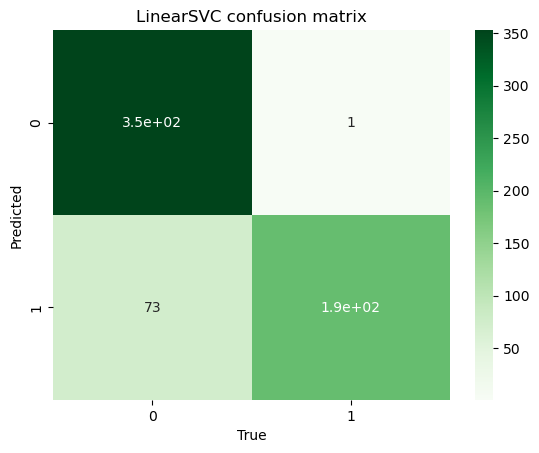

In [250]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [251]:
net.model_.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 50)                11600     
                                                                 
 dense_57 (Dense)            (None, 50)                2550      
                                                                 
 dense_58 (Dense)            (None, 50)                2550      
                                                                 
 dense_59 (Dense)            (None, 2)                 102       
                                                                 
Total params: 16,802
Trainable params: 16,802
Non-trainable params: 0
_________________________________________________________________


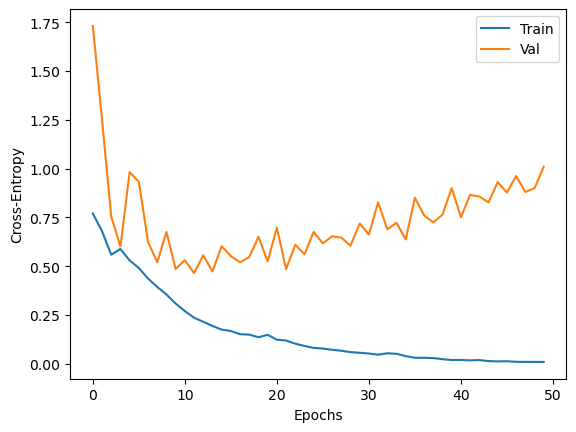

In [252]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

20/20 [==============================] - 0s 1ms/step


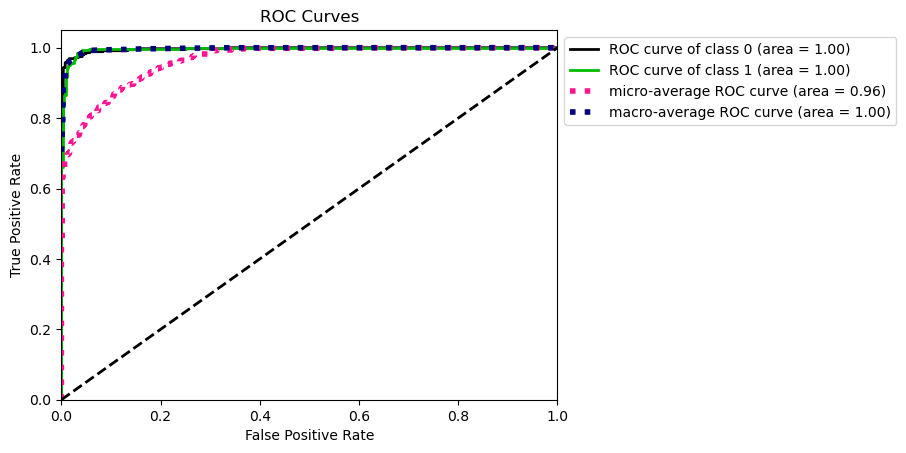

0.9961292965886056


In [253]:
y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Ensemble methods

## Random Forest

In [254]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [255]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-10 14:48:01,523] A new study created in memory with name: no-name-ffdf2921-a772-4579-89f7-b6c8f8ecac01
[W 2023-06-10 14:48:05,268] Trial 6 failed with parameters: {'n_estimators': 880, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'gini'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\

[W 2023-06-10 14:48:13,833] Trial 14 failed with parameters: {'n_estimators': 1110, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 2, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\U

[W 2023-06-10 14:48:29,171] Trial 27 failed with value None.
[W 2023-06-10 14:48:29,428] Trial 28 failed with parameters: {'n_estimators': 520, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901, 

[W 2023-06-10 14:48:30,230] Trial 31 failed with value None.
[W 2023-06-10 14:48:30,448] Trial 32 failed with parameters: {'n_estimators': 590, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901, 

[W 2023-06-10 14:48:31,778] Trial 37 failed with value None.
[I 2023-06-10 14:48:32,358] Trial 24 finished with value: 0.875 and parameters: {'n_estimators': 660, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 11 with value: 0.925.
[I 2023-06-10 14:48:33,355] Trial 15 finished with value: 0.875 and parameters: {'n_estimators': 1740, 'max_depth': 80, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 11 with value: 0.925.
[W 2023-06-10 14:48:33,608] Trial 40 failed with parameters: {'n_estimators': 480, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1').
Traceback (most recent call last):
  File

[W 2023-06-10 14:48:37,058] Trial 44 failed with parameters: {'n_estimators': 450, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901, in d

[W 2023-06-10 14:48:39,988] Trial 48 failed with value None.
[W 2023-06-10 14:48:40,643] Trial 49 failed with parameters: {'n_estimators': 1290, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

In [256]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 610, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       354
           1       0.98      0.92      0.95       262

    accuracy                           0.96       616
   macro avg       0.96      0.95      0.96       616
weighted avg       0.96      0.96      0.96       616

Accuracy 0.9577922077922078
F1-score [0.9640884 0.9488189]


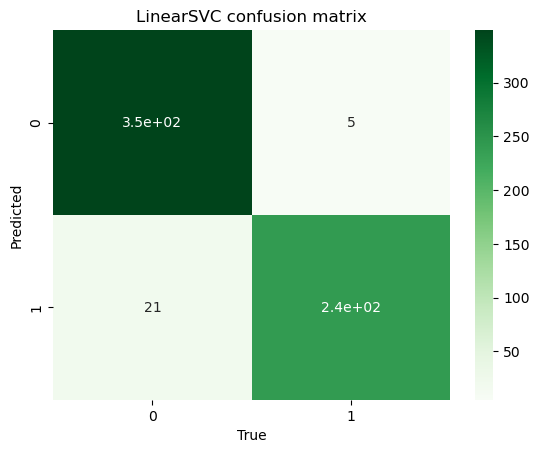

In [257]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

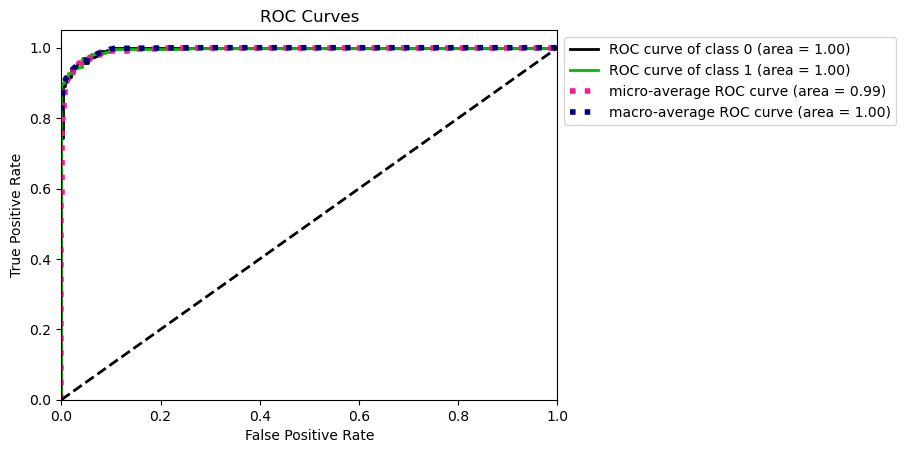

0.9952343985854142


In [258]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

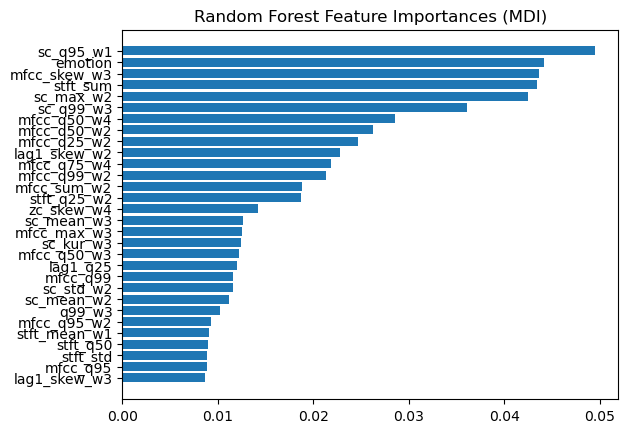

In [259]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [260]:
from sklearn.inspection import permutation_importance

In [261]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

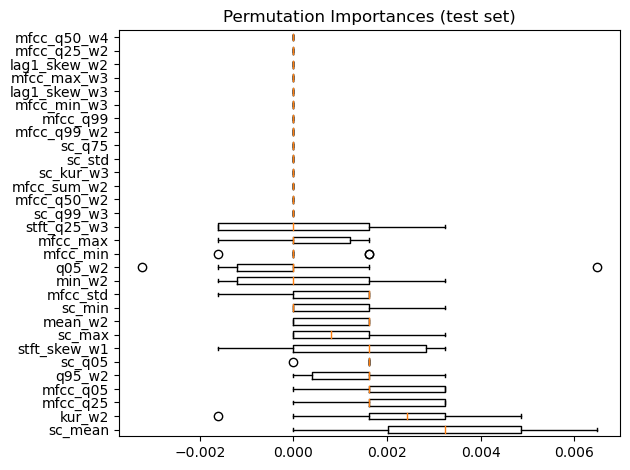

In [262]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [263]:
from sklearn.tree import plot_tree

In [264]:
rf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=12,
                       random_state=130749790)

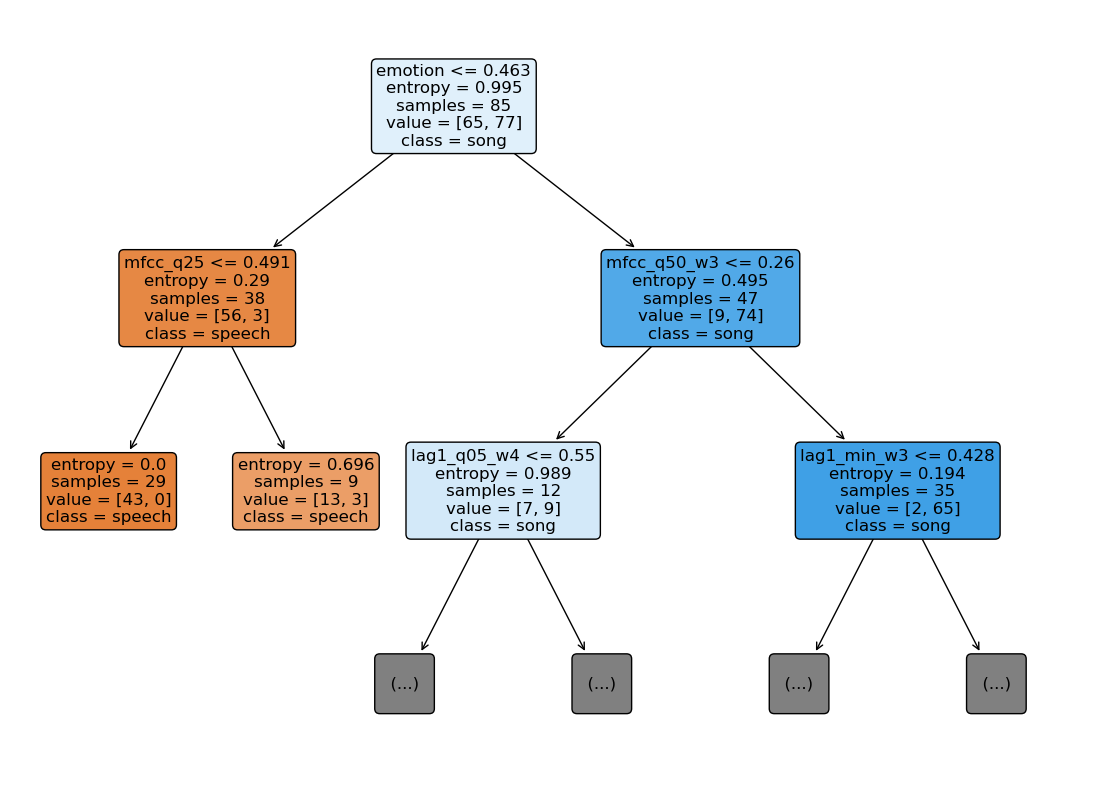

In [265]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

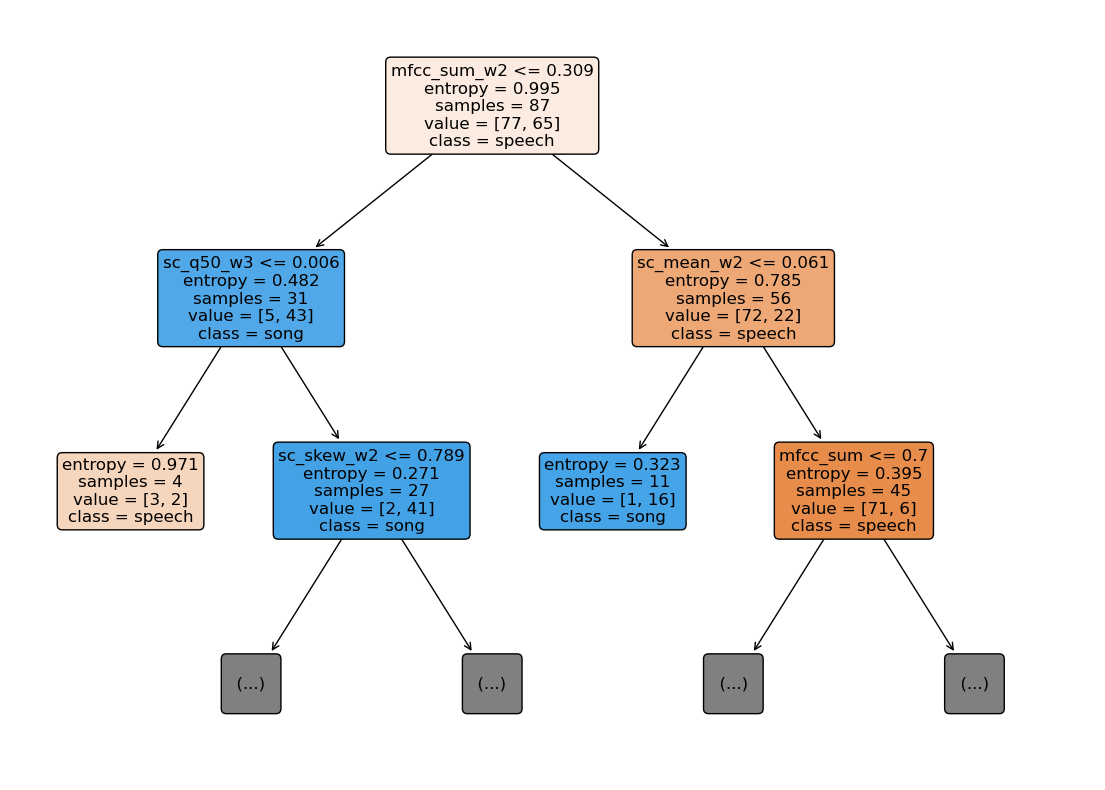

In [266]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [267]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [268]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-06-10 14:50:44,409] A new study created in memory with name: no-name-cf6a8fb2-226c-40e7-b229-9e61c0e08ce0
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-10 14:50:44,423] Trial 0 failed with parameters: {'n_estimators': 1, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 3, 'learning_rate': 0.19573070087906516, 'criterion': 'm

[W 2023-06-10 14:50:44,468] Trial 8 failed with parameters: {'n_estimators': 20, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 6, 'learning_rate': 0.13055557636989143, 'criterion': 'mae', 'subsample': 0.736580187087207, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 
[W

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-10 14:50:44,808] Trial 17 failed with parameters: {'n_estimators': 5, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 5, 'learning_rate': 0.27286164479909697, 'criterion': 'friedman_mse', 'subsample': 0.8935908088149358, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
   

[W 2023-06-10 14:50:45,124] Trial 22 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be 

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-10 14:50:45,608] Trial 29 failed with parameters: {'n_estimators': 6, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.2976201972839791, 'criterion': 'friedman_mse', 'subsample': 0.5927436940106344, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    

[W 2023-06-10 14:50:46,238] Trial 33 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-10 14:50:46,278] Trial 34 failed with value None.
[I 2023-06-10 14:50:46,313] Trial 27 finished with value: 0.875 and parameters: {'n_estimators': 5, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 2, 'learning_rate': 0.017088732723583445, 'criterion': 'mae', 'subsample': 0.6026730382010812, 'loss': 'deviance'}. Best is trial 4 with value: 0.875.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-10 14:50:46,528] Trial 35 failed with parameters: {'n_estimato

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-10 14:50:46,944] Trial 40 failed with parameters: {'n_estimators': 14, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.29864636151349233, 'criterion': 'friedman_mse', 'subsample': 0.5016693550973941, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
   

[W 2023-06-10 14:50:47,428] Trial 45 failed with value None.
[W 2023-06-10 14:50:47,460] Trial 47 failed with value None.
[W 2023-06-10 14:50:47,509] Trial 48 failed with value None.
[W 2023-06-10 14:50:47,571] Trial 49 failed with parameters: {'n_estimators': 6, 'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.2959547061086894, 'criterion': 'friedman_mse', 'subsample': 0.5237465178008001, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anacond

[W 2023-06-10 14:50:47,893] Trial 53 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-10 14:50:47,928] Trial 51 failed with value None.
[W 2023-06-10 14:50:47,932] Trial 56 failed with parameters: {'n_estimators': 7, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.29787780361083016, 'criterion': 'friedman_mse', 'subsample': 0.8376635622610102, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    g

[W 2023-06-10 14:50:48,430] Trial 63 failed with parameters: {'n_estimators': 7, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.2965088292425606, 'criterion': 'friedman_mse', 'subsample': 0.8445842542327233, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not support

[W 2023-06-10 14:50:49,123] Trial 71 failed with parameters: {'n_estimators': 7, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.2924616940107582, 'criterion': 'friedman_mse', 'subsample': 0.8268314412786375, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not support

[W 2023-06-10 14:50:50,195] Trial 80 failed with parameters: {'n_estimators': 7, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1, 'learning_rate': 0.28025203087933825, 'criterion': 'friedman_mse', 'subsample': 0.8297324913583306, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not suppo

[W 2023-06-10 14:50:50,840] Trial 84 failed with value None.
[W 2023-06-10 14:50:50,942] Trial 87 failed with parameters: {'n_estimators': 7, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.2904612066628568, 'criterion': 'friedman_mse', 'subsample': 0.8229485431121295, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported

[W 2023-06-10 14:50:51,488] Trial 91 failed with value None.
[W 2023-06-10 14:50:51,548] Trial 92 failed with value None.
[W 2023-06-10 14:50:51,584] Trial 95 failed with parameters: {'n_estimators': 6, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1, 'learning_rate': 0.2935312812065977, 'criterion': 'friedman_mse', 'subsample': 0.8446116894458077, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_21664\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _

In [269]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 7, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.25575782643554446, 'criterion': 'friedman_mse', 'subsample': 0.619778376283856, 'loss': 'exponential'}
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       354
           1       0.96      0.74      0.83       262

    accuracy                           0.88       616
   macro avg       0.90      0.86      0.87       616
weighted avg       0.89      0.88      0.87       616

Accuracy 0.875
F1-score [0.89960887 0.8344086 ]


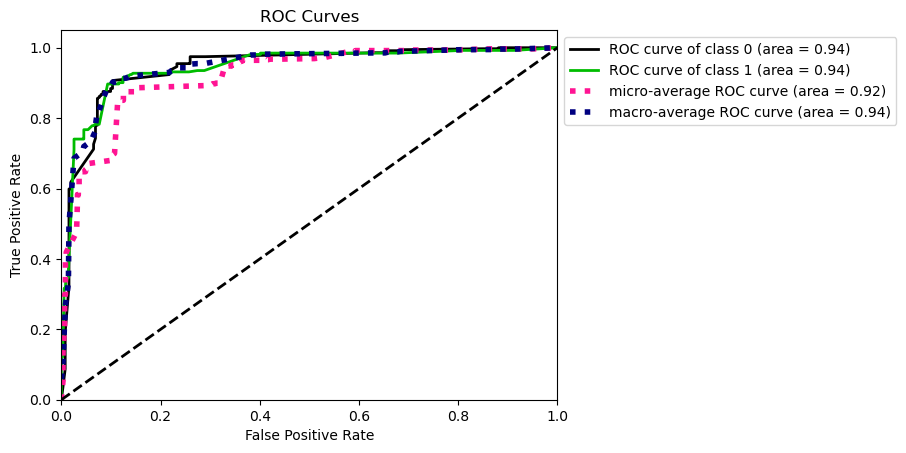

0.9436591624617242


In [270]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))